# W207 Final Project – San Francisco Crime Classification
### By: Daghan, Jerry, and PJ

Import libraries to facilitate data acquisition & processing, data exploration & visualization, feature engineering, and machine learning experimentation.

In [1]:
%matplotlib inline

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# Data Structure
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import log_loss
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.svm import SVC

# Others
from datetime import datetime
import re
import zipfile
import os.path
import random
import math

### Define Helper Functions

In [2]:
def print_full(statement):
    pd.set_option('display.max_rows', len(statement))
    print(statement)
    pd.reset_option('display.max_rows')

# DATA ACQUISITION

### Import Data from Kaggle: https://www.kaggle.com/c/sf-crime/data

In [3]:
# Load the data and examine it
if os.path.isfile('./train.csv'):
    train_data = pd.read_csv('./train.csv')
else:
    z = zipfile.ZipFile('./train.csv.zip')
    train_data = pd.read_csv(z.open('train.csv'))

print("Shape of train_data:", train_data.shape)
train_data.head()

('Shape of train_data:', (878049, 9))


Dates        Category                      Descript  \
0  2015-05-13 23:53:00        WARRANTS                WARRANT ARREST   
1  2015-05-13 23:53:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
2  2015-05-13 23:33:00  OTHER OFFENSES      TRAFFIC VIOLATION ARREST   
3  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   
4  2015-05-13 23:30:00   LARCENY/THEFT  GRAND THEFT FROM LOCKED AUTO   

   DayOfWeek PdDistrict      Resolution                    Address  \
0  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
1  Wednesday   NORTHERN  ARREST, BOOKED         OAK ST / LAGUNA ST   
2  Wednesday   NORTHERN  ARREST, BOOKED  VANNESS AV / GREENWICH ST   
3  Wednesday   NORTHERN            NONE   1500 Block of LOMBARD ST   
4  Wednesday       PARK            NONE  100 Block of BRODERICK ST   

            X          Y  
0 -122.425892  37.774599  
1 -122.425892  37.774599  
2 -122.424363  37.800414  
3 -122.426995  37.800873  
4 -122.438738  37.771541

In [4]:
if os.path.isfile('./test.csv'):
    test_data = pd.read_csv('./test.csv')
else:
    z = zipfile.ZipFile('./test.csv.zip')
    test_data = pd.read_csv(z.open('test.csv'))

print("Shape of test_data:", test_data.shape)
test_data.head()

('Shape of test_data:', (884262, 7))


Id                Dates DayOfWeek PdDistrict                   Address  \
0   0  2015-05-10 23:59:00    Sunday    BAYVIEW   2000 Block of THOMAS AV   
1   1  2015-05-10 23:51:00    Sunday    BAYVIEW        3RD ST / REVERE AV   
2   2  2015-05-10 23:50:00    Sunday   NORTHERN    2000 Block of GOUGH ST   
3   3  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   
4   4  2015-05-10 23:45:00    Sunday  INGLESIDE  4700 Block of MISSION ST   

            X          Y  
0 -122.399588  37.735051  
1 -122.391523  37.732432  
2 -122.426002  37.792212  
3 -122.437394  37.721412  
4 -122.437394  37.721412

In [5]:
# Import San Francisco map for visualization
map_data = np.loadtxt("./sf_map_copyright_openstreetmap_contributors.txt")
len_width_ratio = map_data.shape[0] * 1.0 / map_data.shape[1]

# DATA CLEANSING

In [6]:
train_data.describe()

X              Y
count  878049.000000  878049.000000
mean     -122.422616      37.771020
std         0.030354       0.456893
min      -122.513642      37.707879
25%      -122.432952      37.752427
50%      -122.416420      37.775421
75%      -122.406959      37.784369
max      -120.500000      90.000000

Display the description of the numerical features to determine outliers. Apparently "Y=90" is an outlier. We will drop samples containing outliers. We should also drop samples with NA feature fields.

In [5]:
print('Before data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
      (train_data.shape[0], test_data.shape[0]))

# Drop samples containing null fields
train_data = train_data.dropna()

# The boundaries of valid longitude and latitude
lon_lat_box = (-122.5247, -122.3366, 37.699, 37.8299)

# Drop samples containing invalide longitude and latitude
train_data = train_data[train_data.X > lon_lat_box[0]]
train_data = train_data[train_data.X < lon_lat_box[1]]
train_data = train_data[train_data.Y > lon_lat_box[2]]
train_data = train_data[train_data.Y < lon_lat_box[3]]

print('After data cleansing, the train data contain %d samples, the test data contain %d samples.' % \
      (train_data.shape[0], test_data.shape[0]))

Before data cleansing, the train data contain 878049 samples, the test data contain 884262 samples.
After data cleansing, the train data contain 877982 samples, the test data contain 884262 samples.


# DATA EXPLORATION

The primary goal of this project is to "predict the category of a crime that occurred, given time and location", paraphrased from the Kaggle description. Kaggle is "also encouraging [kagglers] to explore the dataset visually." Despite the usefulness of the .head() method in the previous section, further inspection of the data is warranted, especially to better understand the crime category (since that's what we're predicting) as well as time and location (since these are the primary features).

### CRIME – What are these crime categories?

A brief exploration of the crime category section follows, before examining it with respect to time and location. The most important visualizations we chose to keep were 1) a simple chart showing the overall crime distribution without the burden of instrusive labels and 2) a Pareto chart – a duality of bar and line charts that simply and succinctly illustrates both absolute counts and cumulative percentages, while also displaying the labels (since although potentially distracting in a graph, understanding the labels in perspective is essential for later feature engineering and error analysis).

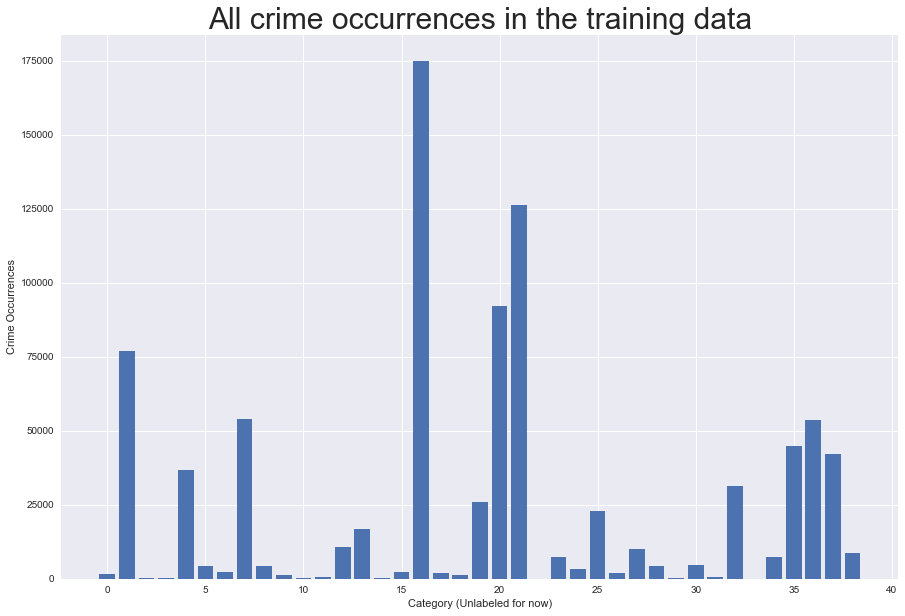

In [8]:
# Simple bar chart of all crime occurrences in the training data set
categories = dict([(category, group.shape[0]) for category, group in train_data.groupby(train_data["Category"])])

fig = plt.figure(figsize=(15,10))
plt.bar(np.arange(len(categories)), list(categories.values()))
plt.title("All crime occurrences in the training data", fontsize=30)
plt.ylabel("Crime Occurrences")
plt.xlabel("Category (Unlabeled for now)")
plt.show()

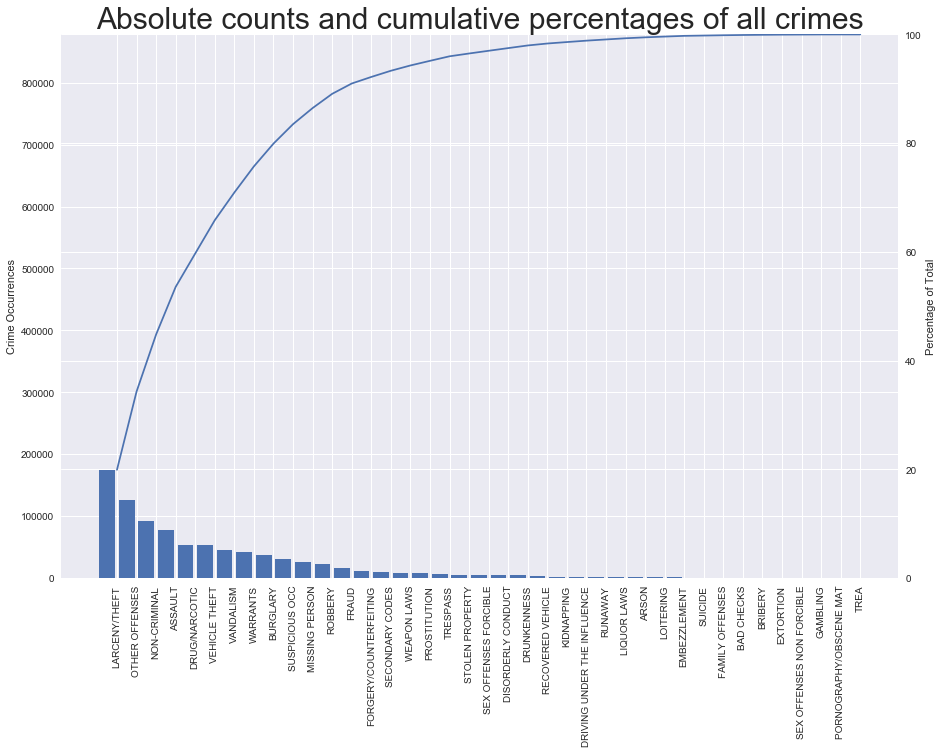

The top 9 crimes account for 80% of all instances, the top 5 account for 60%, and the top crime accounts for 20%!

As seen above, these are the 39 crime categories:
LARCENY/THEFT                  174885
OTHER OFFENSES                 126165
NON-CRIMINAL                    92300
ASSAULT                         76872
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53772
VANDALISM                       44724
WARRANTS                        42206
BURGLARY                        36754
SUSPICIOUS OCC                  31412
MISSING PERSON                  25989
ROBBERY                         22999
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7325
STOLEN PROPERTY                  4539
SEX OFFENSES FORCIBLE            4387
DISORDERLY CONDUCT               4318
DRUNKENNESS                      4280

In [9]:
categories = dict([(category, group.shape[0]) for category, group in train_data.groupby(train_data["Category"])])

# Dissolve the categories dictionary into a sorted list of values, then labels in descending order
categories = sorted(categories.items(), key=lambda x: x[1], reverse=True)
categories, counts = ([item[0] for item in categories], [item[1] for item in categories])

# Create a Pareto Chart
fig = plt.figure(figsize=(15,10))
ind = np.arange(len(categories))

# Bar chart of category and count
ax1 = fig.add_subplot(111)
ax1.bar(ind, counts)
ax1.set_xticks(ind + .5)
ax1.set_xticklabels(categories, rotation=90)
ax1.set_ylim(ymax=sum(counts))
ax1.set_ylabel("Crime Occurrences")

# Co-plotted line chart of percentages
ax2 = ax1.twinx()
percent = 100*np.cumsum(counts)/sum(counts)
ax2.plot(ind + .5, percent)
ax2.set_ylim(0, 100)
ax2.set_ylabel("Percentage of Total")

plt.title("Absolute counts and cumulative percentages of all crimes", fontsize=30)
plt.show()

print("The top 9 crimes account for 80% of all instances, the top 5 account for 60%, and the top crime accounts for 20%!\n")

# Show all available crime lables with exact numbers in a format that does not require head-turning
crime_categories = train_data['Category'].value_counts()
print('As seen above, these are the %d crime categories:' % (len(crime_categories)))
print(crime_categories)
crime_category_names = crime_categories.index

# Show the percentage of the mode in all data.
print('\nThe percentage of LARCENY/THEFT (the most commonly occurring crime) is: ' + str(round(100*crime_categories[0] * 1.0 / train_data.shape[0], 2)) + '%')
print('When predicting, if the model is worse than always predicting the mode, it may be beneficial to always predict the mode (LARCENY/THEFT).')

From the visualizations above, it is apparent that not all crimes are equal, at least in terms of how common they are. Next, we will examine which areas in San Francisco are more prone to certain types of crime, then finally visualize the time dimension to determine whether crime truly doesn't sleep.

### LOCATION – Where do crimes occur?

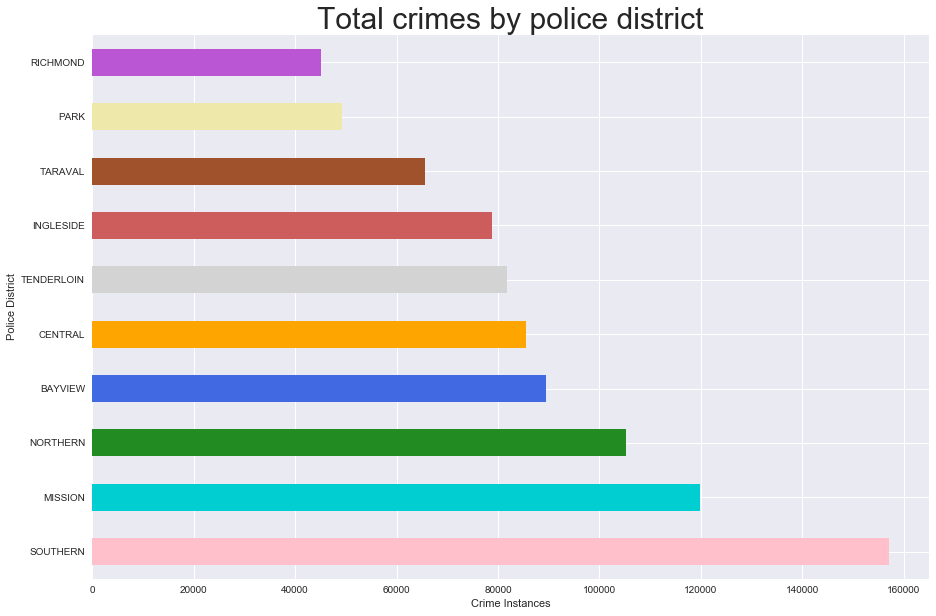

In [10]:
fig = plt.figure(figsize=(15,10))
colors = ["pink", "darkturquoise", "forestgreen", "royalblue", "Orange", "lightgrey", "indianred", "sienna", "palegoldenrod", "mediumorchid"]
train_data["Category"].groupby(train_data["PdDistrict"]).count().sort_values(ascending=False).plot(kind='barh', color=colors)
plt.title("Total crimes by police district", fontsize=30)
plt.xlabel("Crime Instances")
plt.ylabel("Police District")
plt.show()

Top 5 crimes per district, on the same scale (0 to 45,000 instances)


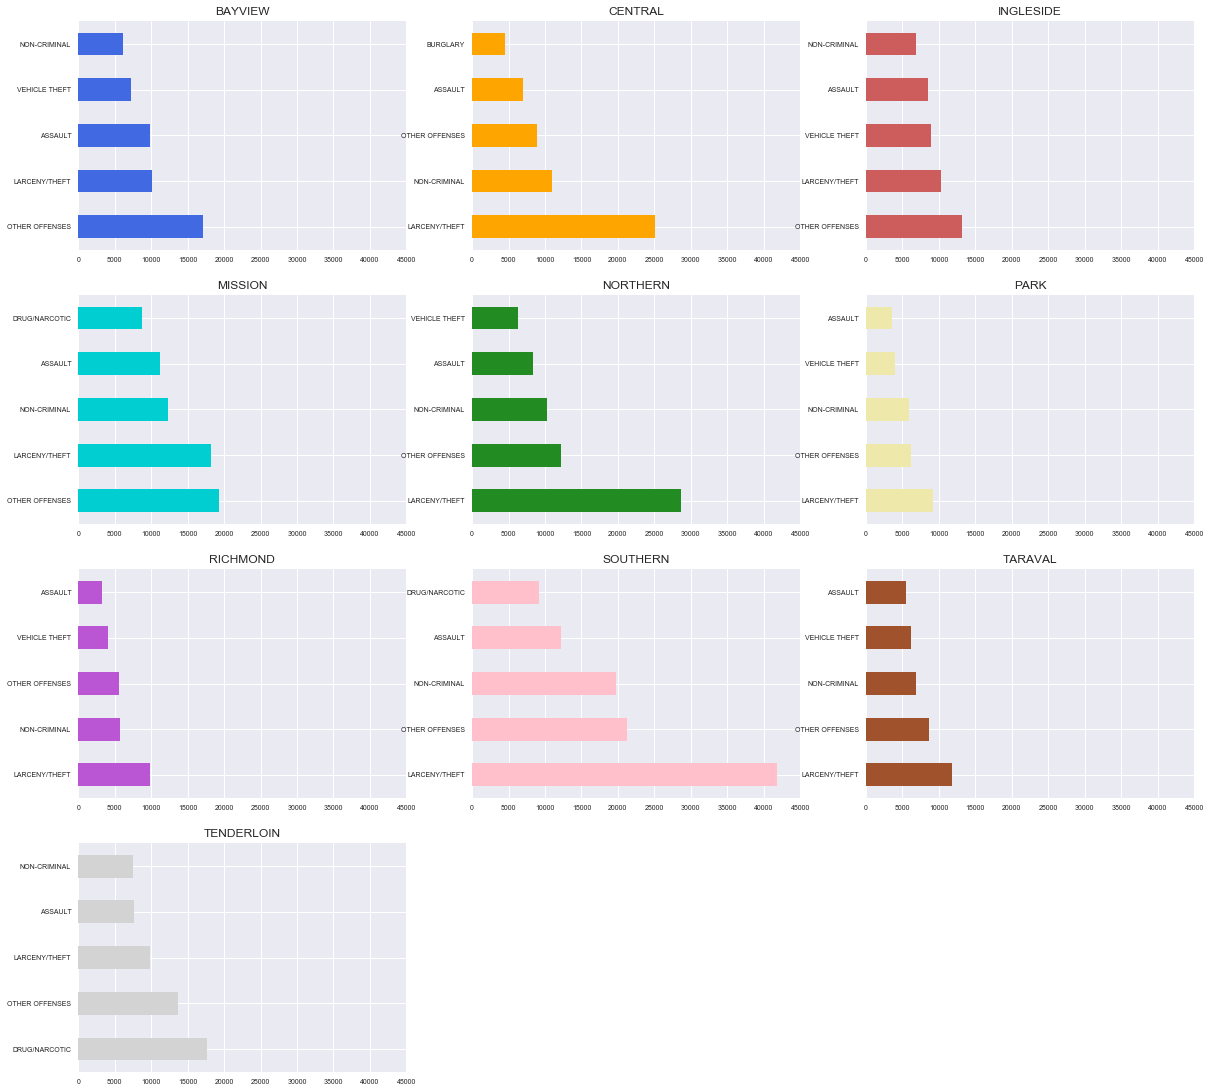

In [11]:
print("Top 5 crimes per district, on the same scale (0 to 45,000 instances)")
plt.figure(figsize=(20, 100))
colors = ["royalblue", "Orange", "indianred", "darkturquoise", "forestgreen", "palegoldenrod", "mediumorchid", "pink", "sienna", "lightgrey"]
i = 0
for district, group in train_data.groupby(train_data["PdDistrict"]):
    p = plt.subplot(20, 3, i+1)
    group["Category"].value_counts()[:5].plot(kind='barh', axes=p, fontsize=7, xlim=(0,45000), color=colors[i])
    plt.title(district)
    i = i + 1

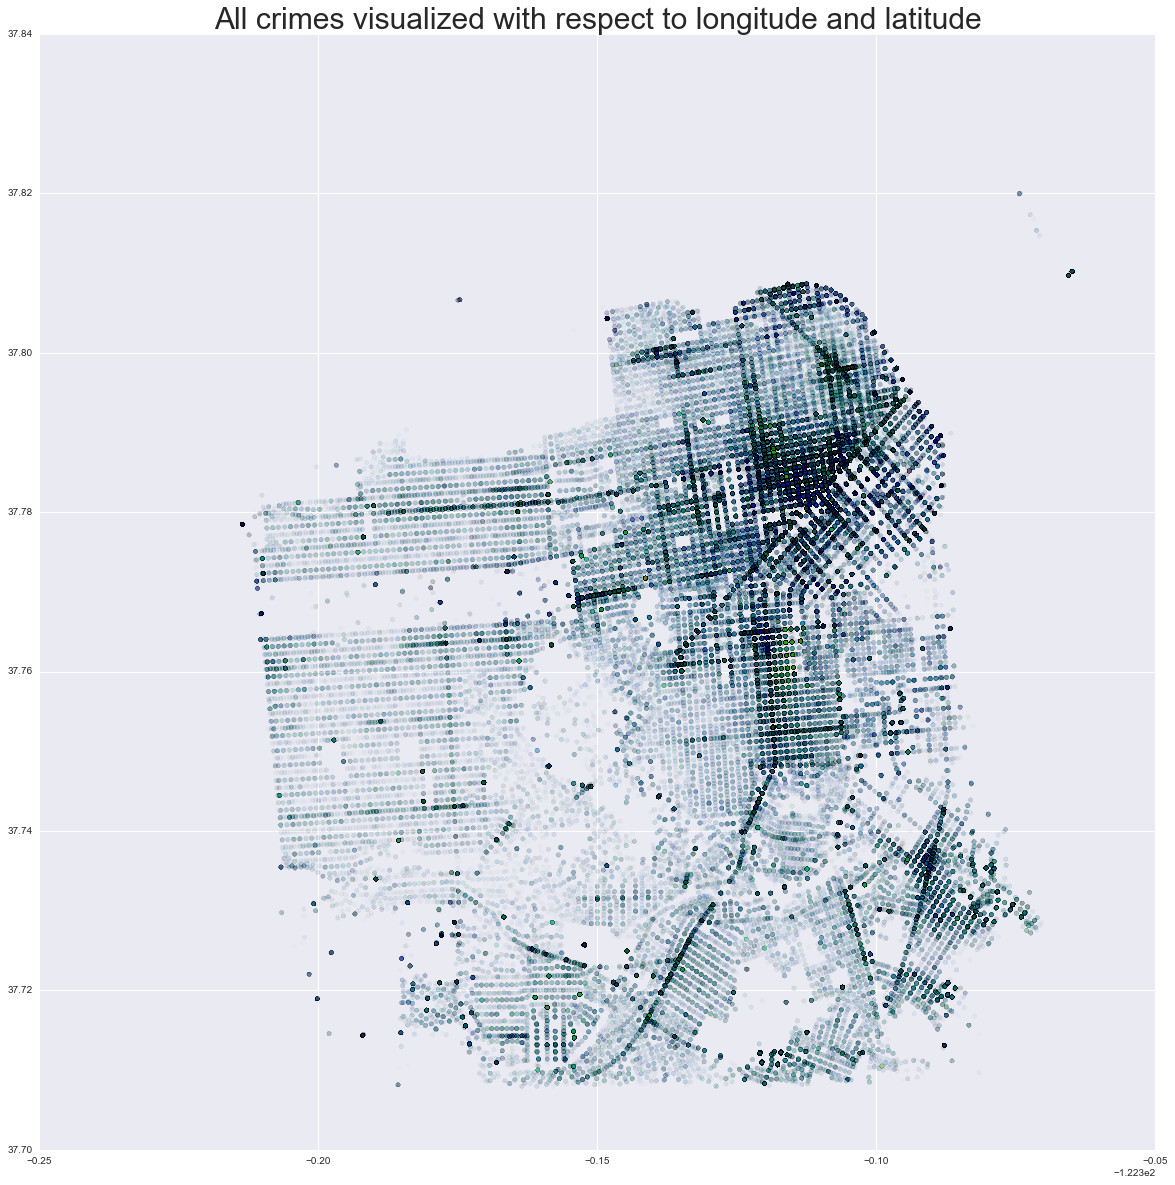

In [96]:
# Assign a color index to each crime category
color_map = dict(zip(crime_category_names, range(len(crime_categories))))

# Draw a scatter plot to show the crimes distribution
plt.figure(figsize=(20,20))
#plt.scatter(train_data.X, train_data.Y, c=train_data.Category.map(color_map), cmap=plt.cm.gist_ncar)
plt.scatter(train_data.X, train_data.Y, c=train_data.Category.map(color_map), cmap=plt.cm.gist_ncar, alpha = 0.01)
plt.title("All crimes visualized with respect to longitude and latitude", fontsize=30)
plt.show()

Apparently, the scatter plot with all crimes is not very helpful. Crimes happened everywhere, and we didn't get deeper insight. We will make the scatter plot of every crime separatedly at the next step.

In [12]:
plt.figure(figsize=(16, 320))

for i in range(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    plt.title(crime + " locations")
    p.scatter(cur_crime_data.X, cur_crime_data.Y, alpha = 0.01)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


We can spot some trends with the scatterplots above, notably that some crimes are more prevalent at particular locations. For example, despite differing in total occurrences, Drug/Narcotic and Prostitution are both crimes that seem to have a high density on the Northeastern tip of SF. On the other hand, Vehicle Theft and Family Offenses are common in all areas of SF, and are spread out seemingly equally. Observing the density plots may help us to understand the concentration of various crimes, so we'll start with Prostitution and sex-related offenses.

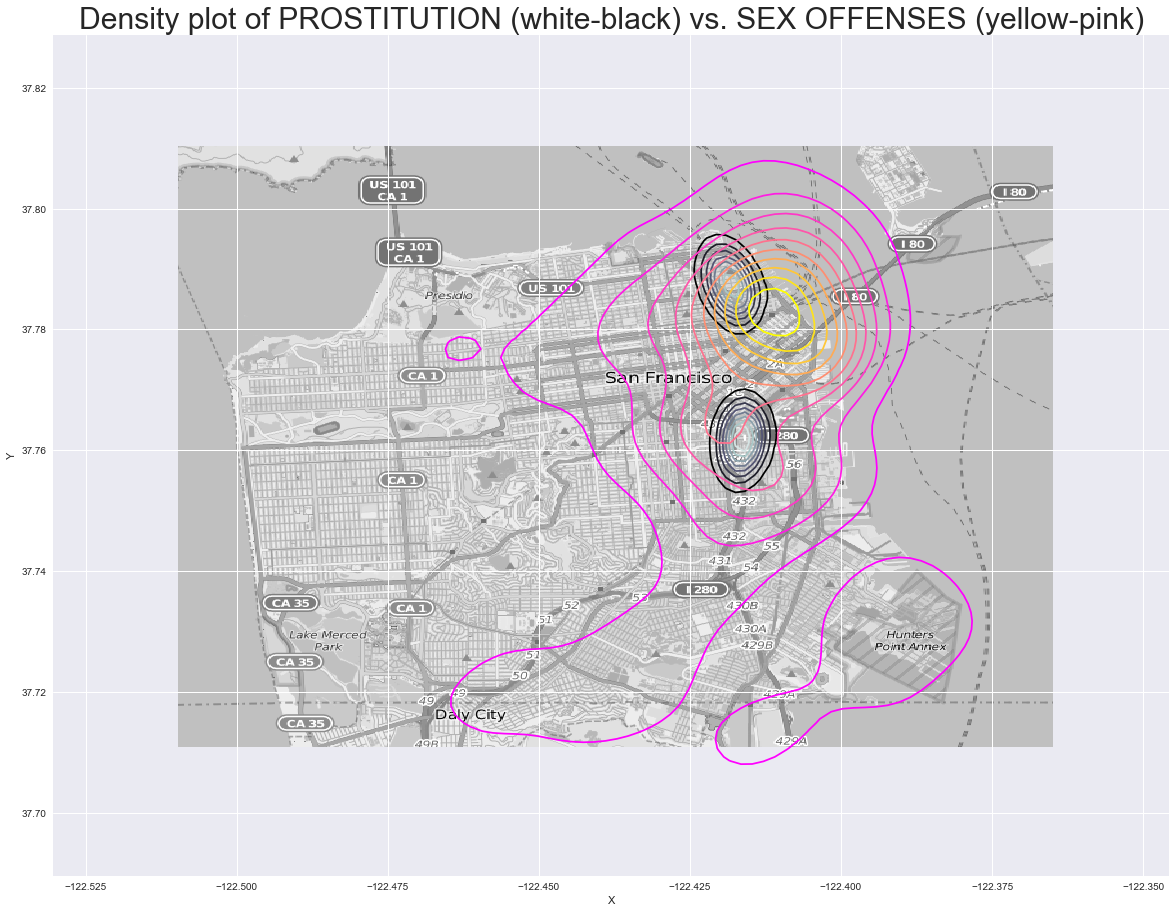

In [13]:
# Examine one type of crime (prostitution, in this case) more closely and compare with related crimes (other sex offenses)

# First, filter relevant data from the training set
prostitution_data = train_data[train_data.Category == "PROSTITUTION"]
sex_offenses = train_data[(train_data.Category == "SEX OFFENSES FORCIBLE") | (train_data.Category == "SEX OFFENSES NON FORCIBLE")]

# Overlay the prostitution location density plot and the sex offenses location density plot over the SF map image
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((prostitution_data.X.min(), prostitution_data.X.max(), prostitution_data.Y.min(), prostitution_data.Y.max()))
plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
sns.kdeplot(prostitution_data.X, prostitution_data.Y, n_levels=10, shade=False, cmap="bone")
sns.kdeplot(sex_offenses.X, sex_offenses.Y, n_levels=10, shade=False, cmap="spring")
plt.title("Density plot of PROSTITUTION (white-black) vs. SEX OFFENSES (yellow-pink)", fontsize=30)
plt.show()

We can observe that the densities for these sex-related crimes are different, and it may be useful to visualize others as well. However, as we saw with the scatterplots above, there are too many categories (30+) to observe on the same map to get a meaninful visual. Further categorization may be beneficial for co-plotting.

In [14]:
# This is an attempt to further categorize the crimes into 6 types + an "other" category

property_related = train_data[(train_data.Category == "LARCENY/THEFT") |
                              (train_data.Category == "VEHICLE THEFT") |
                              (train_data.Category == "VANDALISM") |
                              (train_data.Category == "BURGLARY") |
                              (train_data.Category == "TRESPASS") |
                              (train_data.Category == "STOLEN PROPERTY") |
                              (train_data.Category == "RECOVERED VEHICLE") |
                              (train_data.Category == "ARSON") |
                              (train_data.Category == "ROBBERY")]

person_related = train_data[(train_data.Category == "ASSAULT") |
                              (train_data.Category == "MISSING PERSON") |
                              (train_data.Category == "ROBBERY") |
                              (train_data.Category == "KIDNAPPING") |
                              (train_data.Category == "RUNAWAY") |
                              (train_data.Category == "FAMILY OFFENSES") |
                              (train_data.Category == "SUICIDE")]

drugs_sex_gambling_related = train_data[(train_data.Category == "DRUG/NARCOTIC") |
                              (train_data.Category == "DRUNKENNESS") |
                              (train_data.Category == "LIQUOR LAWS") |
                              (train_data.Category == "DRIVING UNDER THE INFLUENCE") |
                              (train_data.Category == "PROSTITUTION") |
                              (train_data.Category == "SEX OFFENSES FORCIBLE") |
                              (train_data.Category == "SEX OFFENSES NON FORCIBLE") |
                              (train_data.Category == "PORNOGRAPHY/OBSCENE MAT") |
                              (train_data.Category == "GAMBLING")]

weapon_violence_related = train_data[(train_data.Category == "WEAPON LAWS") |
                              (train_data.Category == "ARSON") |
                              (train_data.Category == "SEX OFFENSES FORCIBLE")]

fraudulent_behavior_related = train_data[(train_data.Category == "FRAUD") |
                              (train_data.Category == "FORGERY/COUNTERFEITING") |
                              (train_data.Category == "BAD CHECKS") |
                              (train_data.Category == "EMBEZZLEMENT") |
                              (train_data.Category == "BRIBERY") |
                              (train_data.Category == "EXTORTION") |
                              (train_data.Category == "TREA")]

general_misconduct_related = train_data[(train_data.Category == "LOITERING") |
                              (train_data.Category == "DISORDERLY CONDUCT") |
                              (train_data.Category == "SUSPICIOUS OCC")]

other_related = train_data[(train_data.Category == "OTHER OFFENSES") |
                              (train_data.Category == "NON-CRIMINAL") |
                              (train_data.Category == "WARRANTS") |
                              (train_data.Category == "SECONDARY CODES")]

Now that there are only 7 categories, we could try co-plotting the primary 6 and inspecting the "other" crimes

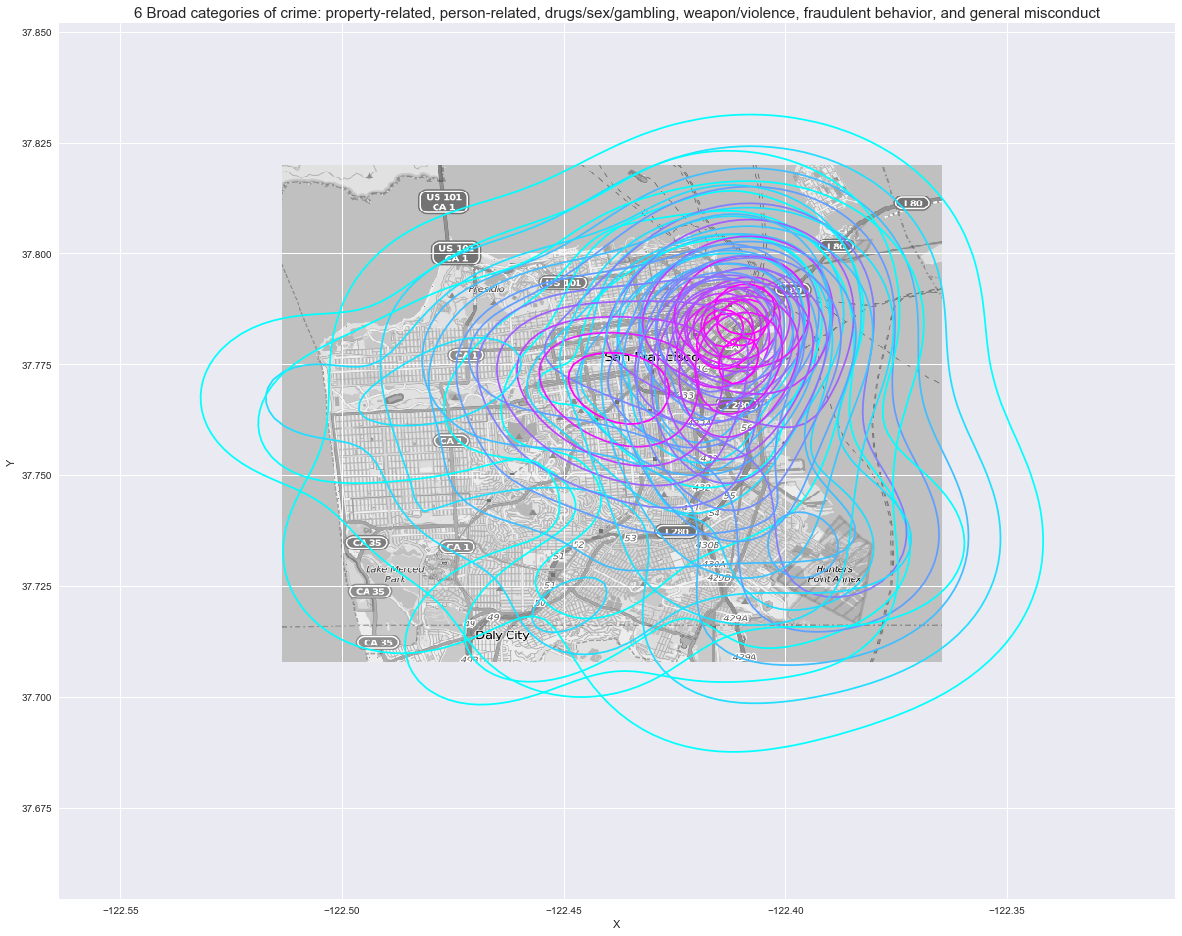

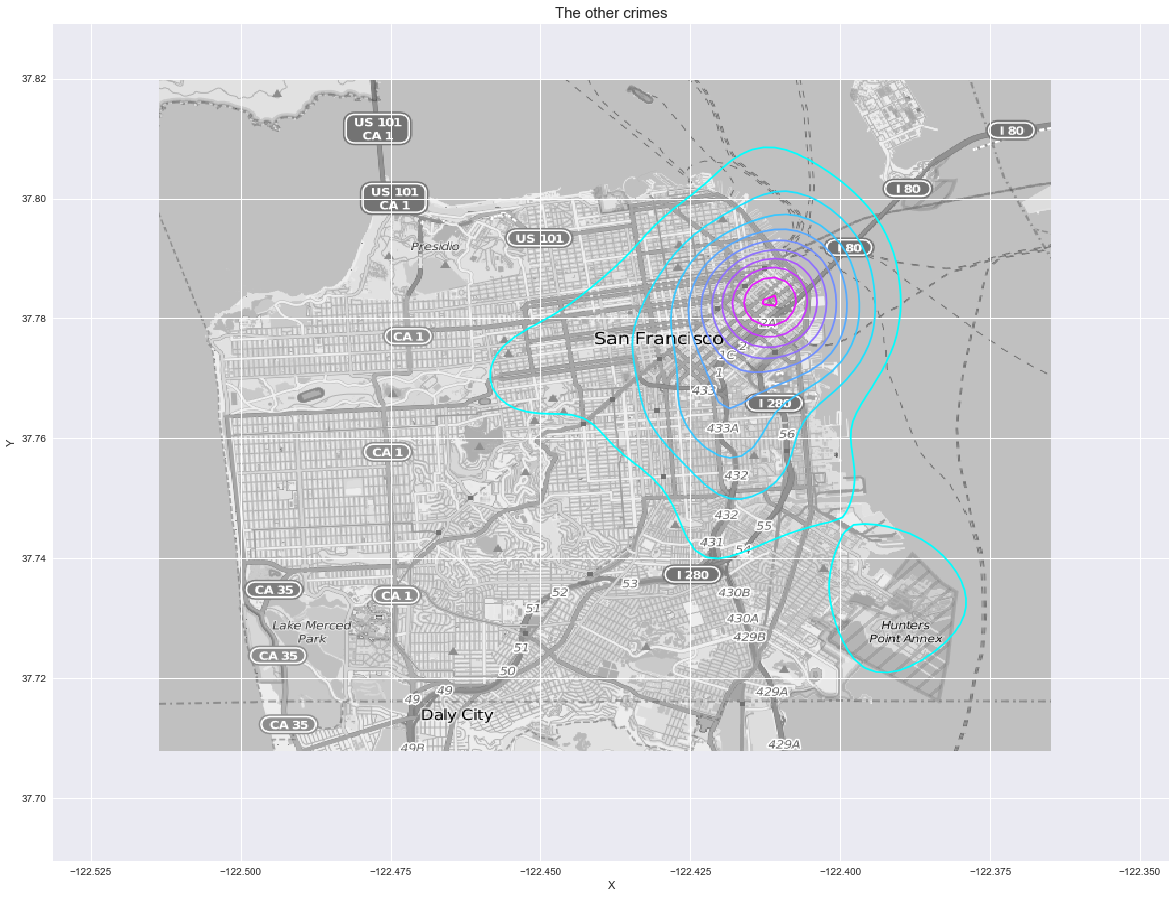

In [15]:
# Examine the 6 broader categories of crime
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((train_data.X.min(), train_data.X.max(), train_data.Y.min(), train_data.Y.max()))

plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
for df, name in zip([property_related, person_related, drugs_sex_gambling_related, weapon_violence_related,
                     fraudulent_behavior_related, general_misconduct_related], 
                    ["Property-related", "Person-related", "Drugs/Sex/Gambling", "Weapon/Violence",
                     "Fraudulent Behavior", "General Misconduct"]):
    shuffle = np.random.permutation(np.arange(df.shape[0]))
    samples = df.iloc[shuffle][:len(df)//1000]
    sns.kdeplot(samples.X, samples.Y, n_levels=10, shade=False, cmap="cool")
plt.title("6 Broad categories of crime: property-related, person-related, drugs/sex/gambling, weapon/violence, fraudulent behavior, and general misconduct", fontsize=15)
plt.show()

# Examine "Other Crimes" as the 7th category
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((other_related.X.min(), other_related.X.max(), other_related.Y.min(), other_related.Y.max()))

plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
shuffle = np.random.permutation(np.arange(other_related.shape[0]))
samples = other_related.iloc[shuffle][:len(other_related)//100]
sns.kdeplot(samples.X, samples.Y, n_levels=10, shade=False, cmap="cool")
plt.title("The other crimes", fontsize=15)
plt.show()

Even though fewer categories were used, the co-plot still looks messy. One immediate insight that can be gleaned is that highest crime densities, regardless of the category, are situated in the Northeastern Tip. "Other," nonspecific crimes do not tend to deviate past this hub, perhaps indicating that crime in Western SF may be more likely to be specific (or police are more likely to categorize it as specific, and hence issue an arrest under this more specific category)

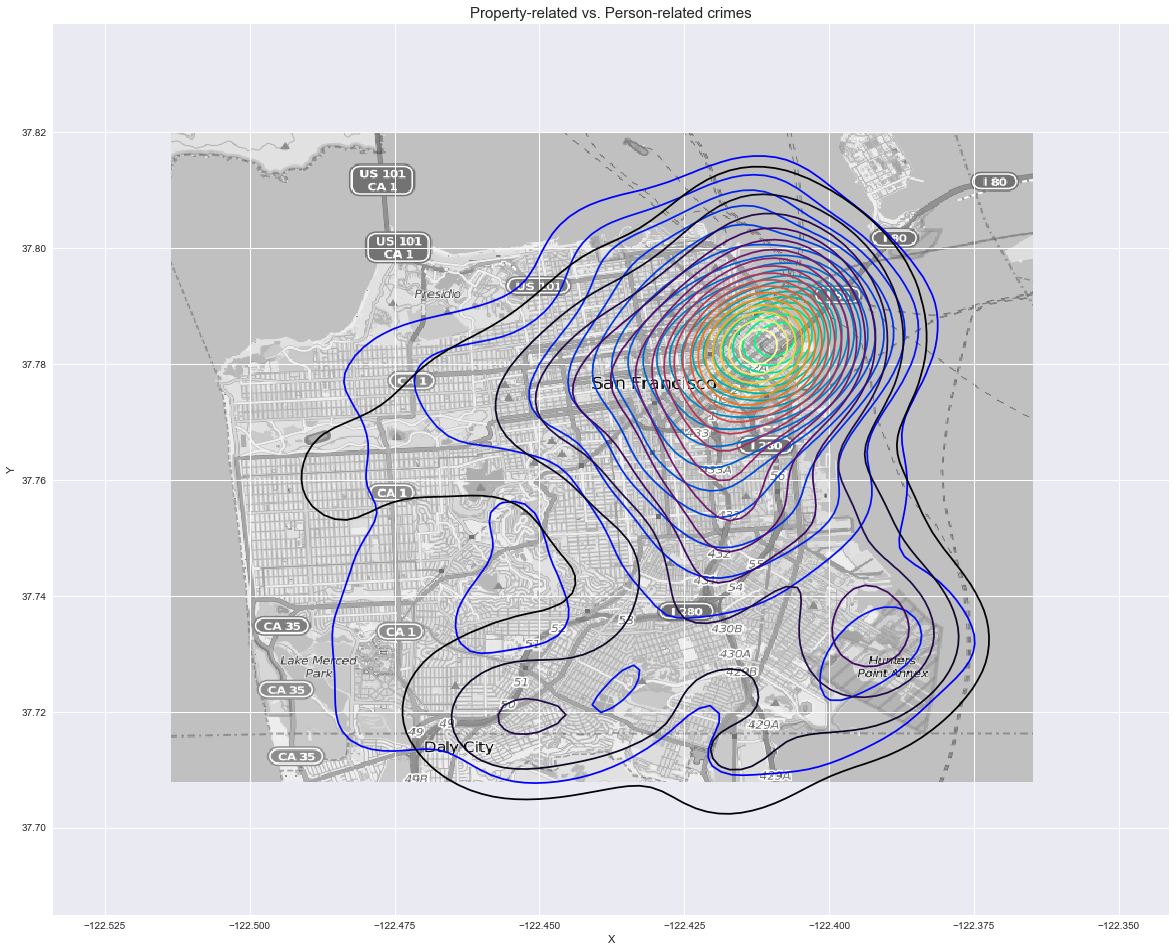

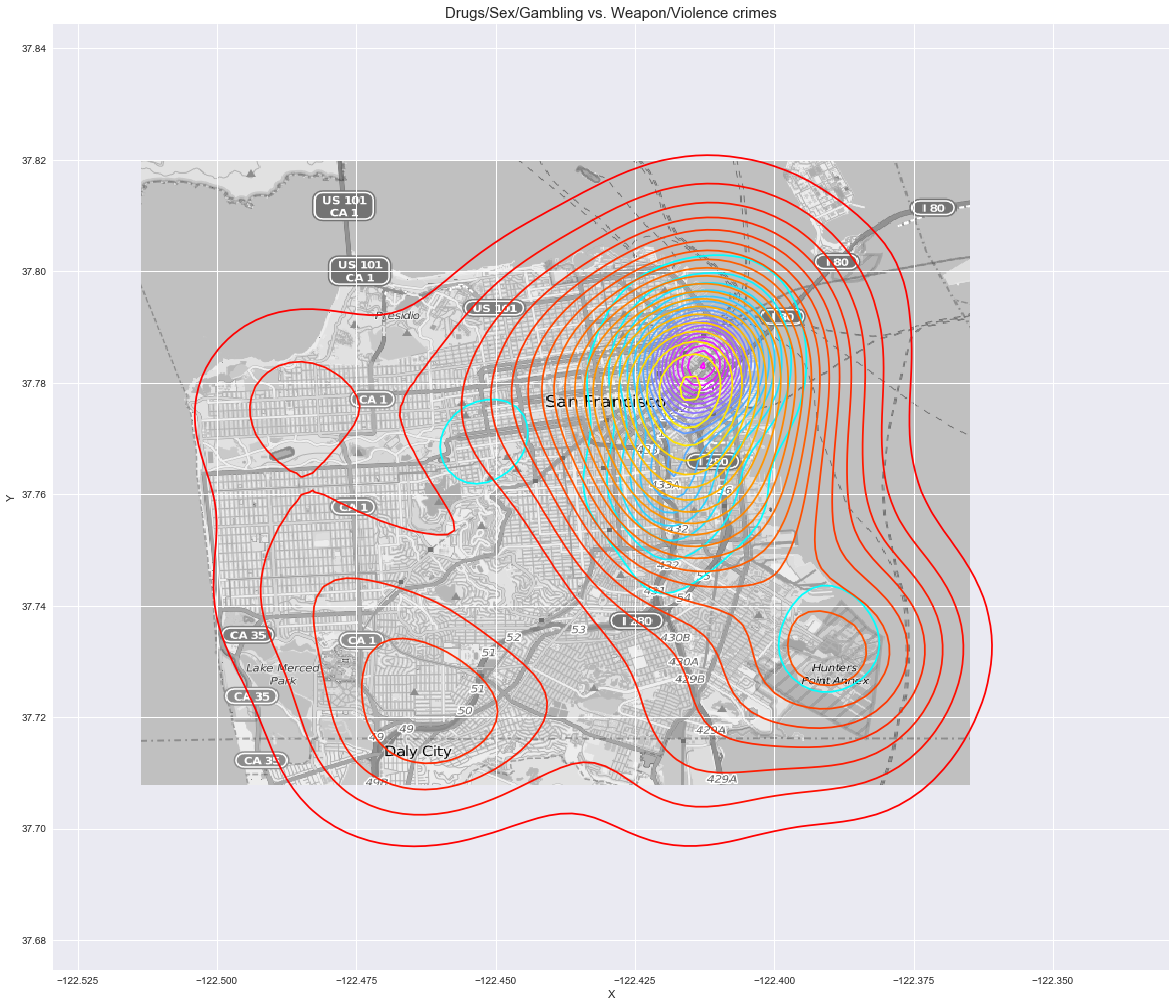

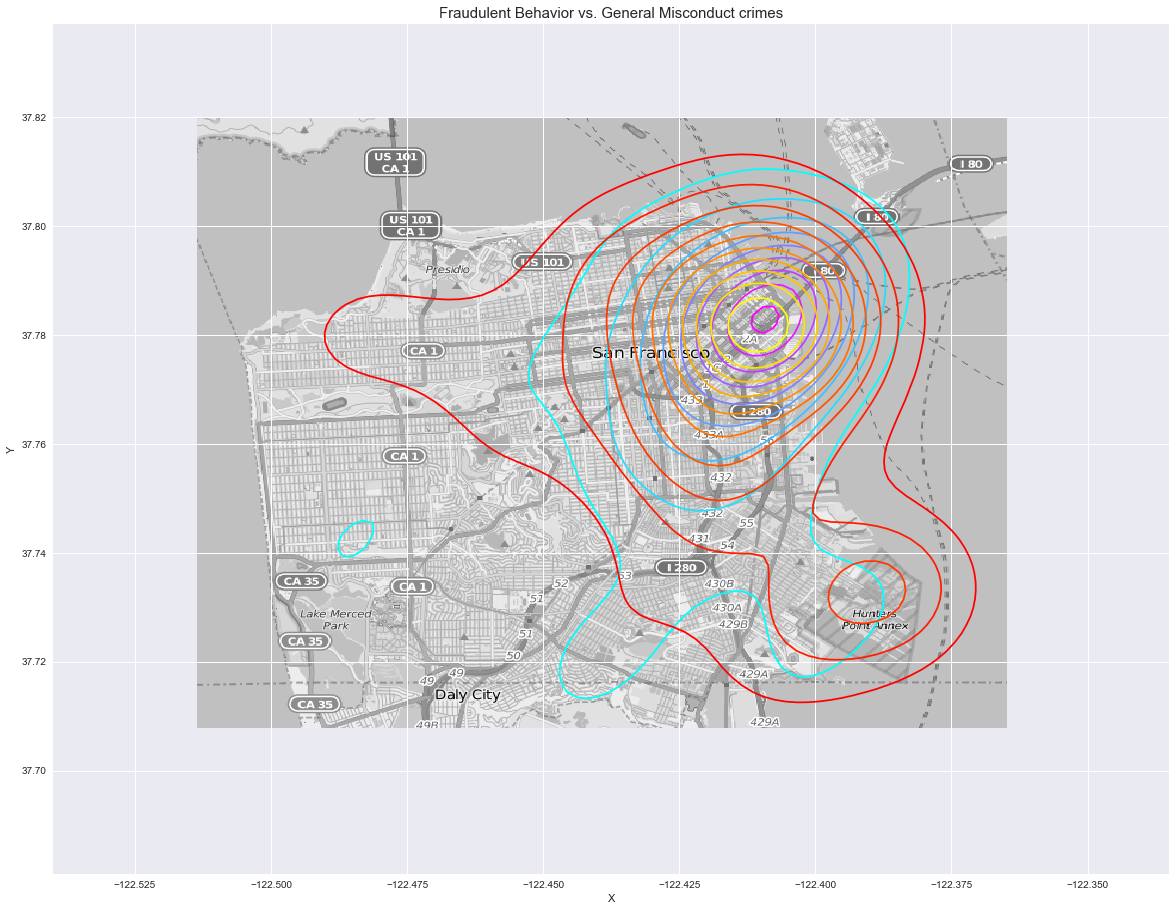

In [16]:
# Visualize density plots for the broad categories against each other

# Do property-related and person-related crimes occur in the same places?
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((train_data.X.min(), train_data.X.max(), train_data.Y.min(), train_data.Y.max()))

plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
for df, name, col in zip([property_related, person_related], ["Property-related", "Person-related"], ["winter", "inferno"]):
    shuffle = np.random.permutation(np.arange(df.shape[0]))
    samples = df.iloc[shuffle][:len(df)//100]
    sns.kdeplot(samples.X, samples.Y, n_levels=20, shade=False, cmap=col)
plt.title("Property-related vs. Person-related crimes", fontsize=15)
plt.show()

# How about drugs, sex, and gambling versus weapon/violence?
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((train_data.X.min(), train_data.X.max(), train_data.Y.min(), train_data.Y.max()))

plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
for df, name, col in zip([drugs_sex_gambling_related, weapon_violence_related], ["Drugs/Sex/Gambling", "Weapon/Violence"], ["cool", "autumn"]):
    shuffle = np.random.permutation(np.arange(df.shape[0]))
    samples = df.iloc[shuffle][:len(df)//100]
    sns.kdeplot(samples.X, samples.Y, n_levels=20, shade=False, cmap=col)
plt.title("Drugs/Sex/Gambling vs. Weapon/Violence crimes", fontsize=15)
plt.show()

# What about fradulent behavior and (typically less serious) general misconduct?
fig, ax = plt.subplots(figsize=(20, 20))
xy_lim = list((train_data.X.min(), train_data.X.max(), train_data.Y.min(), train_data.Y.max()))

plt.imshow(map_data, extent=xy_lim, cmap=plt.get_cmap('gray'))
for df, name, col in zip([fraudulent_behavior_related, general_misconduct_related], ["Fraudulent Behavior", "General Misconduct"], ["cool", "autumn"]):
    shuffle = np.random.permutation(np.arange(df.shape[0]))
    samples = df.iloc[shuffle][:len(df)//100]
    sns.kdeplot(samples.X, samples.Y, n_levels=10, shade=False, cmap=col)
plt.title("Fraudulent Behavior vs. General Misconduct crimes", fontsize=15)
plt.show()

After attempting to recategorize crime categories based on the (human-determined) nature of the crime, there still appears to be overlap. Person- and property-related crimes occur in similar locations, as do fraudulent behavior and general misconduct. The largest visual difference is found to be between the following two types of crime: drugs/sex/gambling and weapon/violence, with the former concentrated slightly farther from the Northeastern Tip than most other crimes, and the latter following a similar pattern to property- and person-related crimes.

### TIME – When do crimes occur?

Besides location, time can also offer a rich set of features. Before delving into detailed feature engineering, let's visually explore the primary source of time-related information: the "Dates" column. From these timestamps, we can focus our attention on hour, month, and year as a starting point.

In [18]:
train_data["Dates"] = pd.to_datetime(train_data["Dates"], format="%Y-%m-%d %H:%M:%S")
train_data["Hour"] = train_data["Dates"].map(lambda x: x.hour)
train_data["Month"] = train_data["Dates"].map(lambda x: x.month)
train_data["Year"] = train_data["Dates"].map(lambda x: x.year)

First, observe the overall trend for all crimes.

CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)


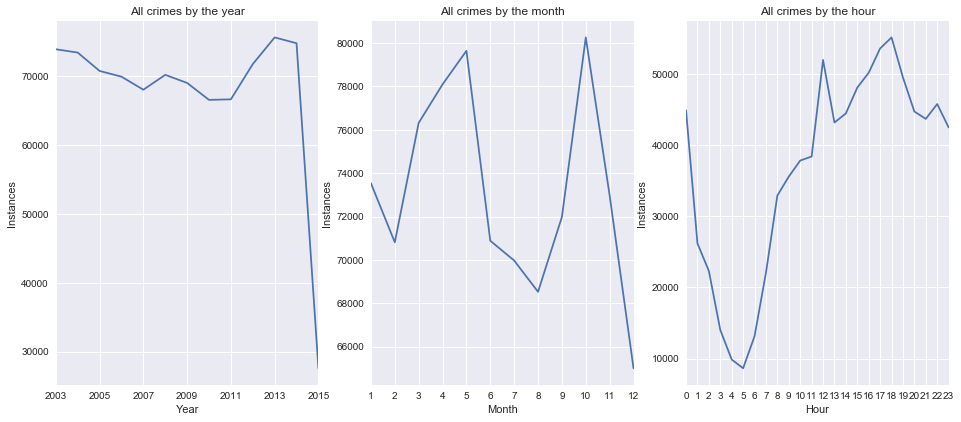

In [19]:
# All crimes by the hour, month, and year
plt.figure(figsize=(16, 320))
print("CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)")
for i, time in zip(range(3), ["Year", "Month", "Hour"]):
    time_data = {}
    p = plt.subplot(40, 3, i+1)
    for unit in train_data[time].unique():
        time_data[unit] = len(train_data[train_data[time] == unit])
        
    # Plot either a line chart (default) or bar chart (uncomment)
    sns.tsplot(data=list(time_data.values()), time=list(time_data.keys()))
    #plt.bar(list(time_data.keys()), list(time_data.values()))
    
    if time == "Year":
        # 1-by-1 tick marks are too close, resulting in label overlap of the years
        plt.xticks(np.arange(train_data[time].unique().min(),train_data[time].unique().max()+1,2))
    else:
        plt.xticks(np.arange(train_data[time].unique().min(),train_data[time].unique().max()+1,1))
    plt.title("All crimes by the " + time.lower())
    plt.ylabel("Instances")
    plt.xlabel(time)

The incidence of all crimes seemed to have decreased recently, with very low counts for 2015 (leftmost chart). Such a steep decrease (>50% reduction) is odd, and may suggest incomplete data for 2015. If we were to give greater weightage to more recent years, including 2013 and 2014 may be more beneficial than 2015 alone. For all other years, crime occurrences remained at relatively constant levels. Although not shown in this notebook, inspection in Tableau revealed that this is also observable for most days of the month for all districts. There does appear to be large variation by the hour, and to a lesser extent, month. An interesting trend is that there are fewer instances of all crimes at particular hours (very early hours of the morning) and months (August and December). So, crime might not actually sleep, but it does appear to nap!

CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)


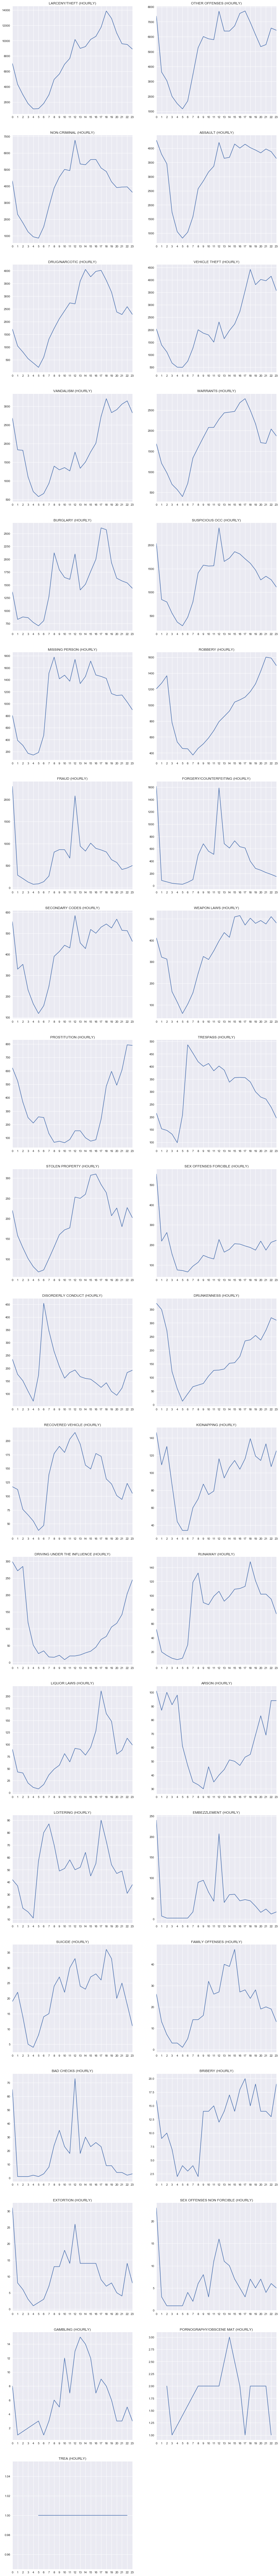

In [20]:
# By the hour
plt.figure(figsize=(16, 320))
print("CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)")
for i in range(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    hourly_data = {}
    for hour in cur_crime_data.Hour.unique():
        hourly_data[hour] = len(cur_crime_data[(cur_crime_data.Hour == hour)])
    sns.tsplot(data=list(hourly_data.values()), time=list(hourly_data.keys()))
    plt.xticks(np.arange(train_data.Hour.unique().min(),train_data.Hour.unique().max()+1,1))
    plt.title(crime + " (HOURLY)")

CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)


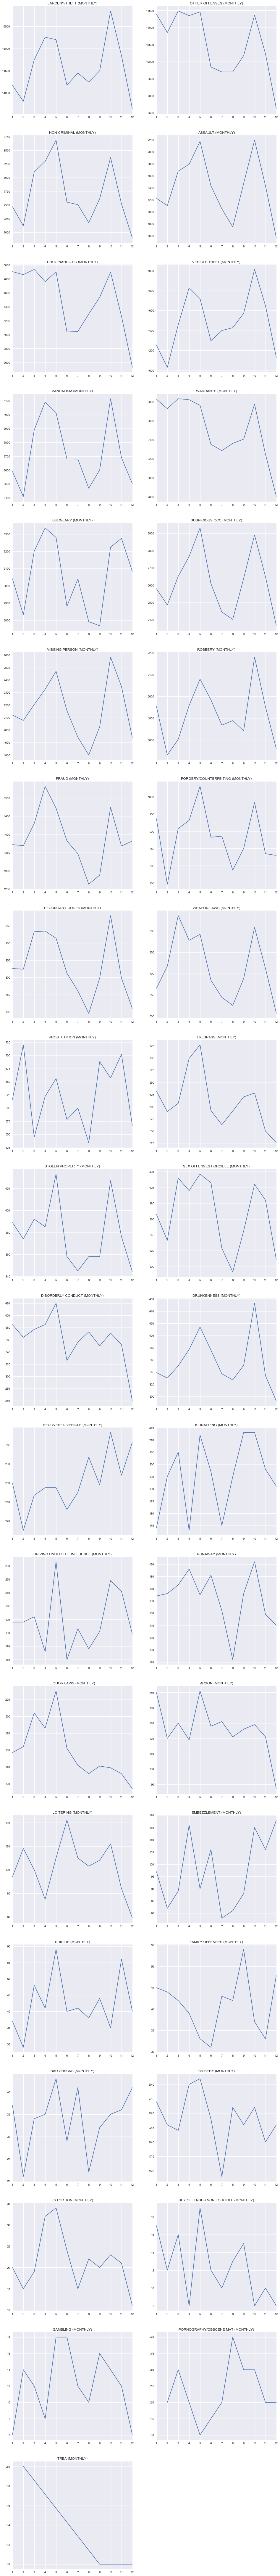

In [22]:
# By the month
plt.figure(figsize=(16, 320))
print("CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)")
for i in range(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    monthly_data = {}
    for month in cur_crime_data.Month.unique():
        monthly_data[month] = len(cur_crime_data[(cur_crime_data.Month == month)])
    sns.tsplot(data=list(monthly_data.values()), time=list(monthly_data.keys()))
    plt.xticks(np.arange(train_data.Month.unique().min(),train_data.Month.unique().max()+1,1))
    plt.title(crime + " (MONTHLY)")
    

CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)


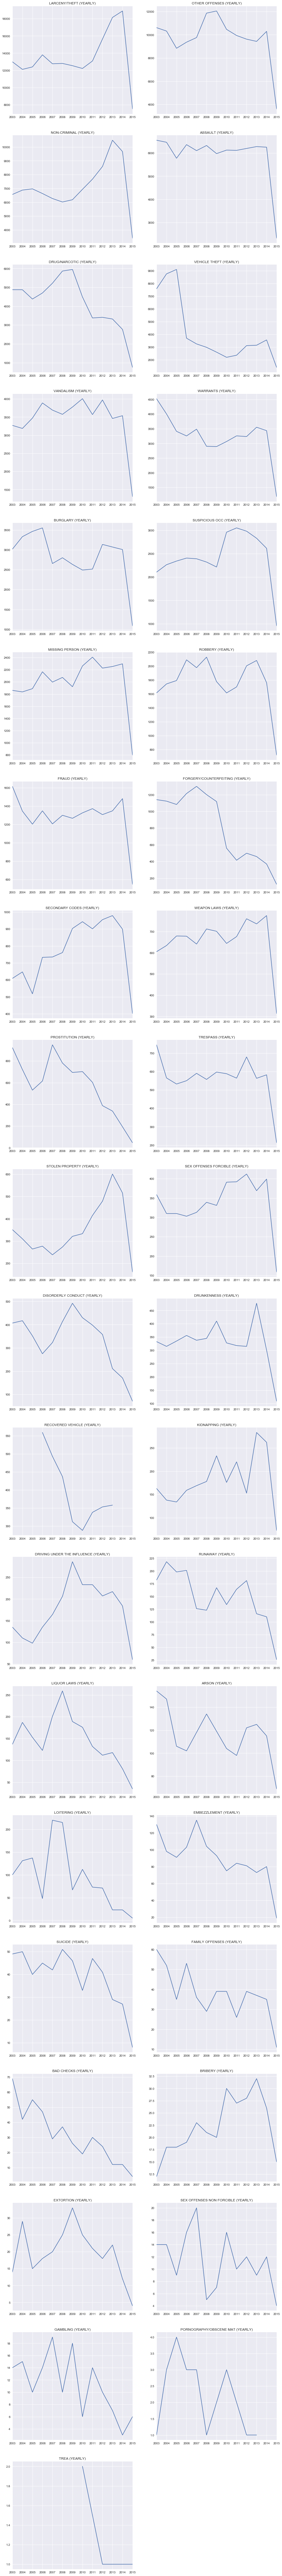

In [23]:
# By the year
plt.figure(figsize=(16, 320))
print("CAUTION: SCALES ARE DIFFERENT (so only use to notice the trend)")
for i in range(len(crime_category_names)):
    p = plt.subplot(40, 2, i+1)
    crime = crime_category_names[i]
    cur_crime_data = train_data[train_data.Category == crime]
    yearly_data = {}
    for year in cur_crime_data.Year.unique():
        yearly_data[year] = len(cur_crime_data[(cur_crime_data.Year == year)])
    sns.tsplot(data=list(yearly_data.values()), time=list(yearly_data.keys()))
    plt.xticks(np.arange(train_data.Year.unique().min(),train_data.Year.unique().max()+1,1))
    plt.title(crime + " (YEARLY)")

In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 12 columns):
Dates         877982 non-null datetime64[ns]
Category      877982 non-null object
Descript      877982 non-null object
DayOfWeek     877982 non-null object
PdDistrict    877982 non-null object
Resolution    877982 non-null object
Address       877982 non-null object
X             877982 non-null float64
Y             877982 non-null float64
Hour          877982 non-null int64
Month         877982 non-null int64
Year          877982 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 87.1+ MB


# Feature Engineering

Partly inspired by the exploratory data analysis and partly by intuition, the features we chose to include and/or engineer are the following:

TIME-related: minute, hour, day, month, year, hour zone, season (removed for final model), week of year, day of week & whether the day is a weekday or weekend

LOCATION-related: street names, type of street, whether it's an on intersection or a block, the closest police district, valid longitude values, valid latitude values, and a series of transformed longitude and latitude values.

In [7]:
# Transform the Date into a python datetime object.
train_data["Dates"] = pd.to_datetime(train_data["Dates"], format="%Y-%m-%d %H:%M:%S")
test_data["Dates"] = pd.to_datetime(test_data["Dates"], format="%Y-%m-%d %H:%M:%S")

In [8]:
# Add Minute
train_data["Minute"] = train_data["Dates"].map(lambda x: x.minute)
test_data["Minute"] = test_data["Dates"].map(lambda x: x.minute)
    
print(sorted(train_data['Minute'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]


In [9]:
# Add Hour
train_data["Hour"] = train_data["Dates"].map(lambda x: x.hour)
test_data["Hour"] = test_data["Dates"].map(lambda x: x.hour)
    
print(sorted(train_data['Hour'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [10]:
# Add Day
train_data["Day"] = train_data["Dates"].map(lambda x: x.day)
test_data["Day"] = test_data["Dates"].map(lambda x: x.day)
    
print(sorted(train_data['Day'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]


In [11]:
# Add Month
train_data["Month"] = train_data["Dates"].map(lambda x: x.month)
test_data["Month"] = test_data["Dates"].map(lambda x: x.month)
    
print(sorted(train_data['Month'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [12]:
# Add Year
train_data["Year"] = train_data["Dates"].map(lambda x: x.year - 2003)   
test_data["Year"] = test_data["Dates"].map(lambda x: x.year - 2003)

print(sorted(train_data['Year'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [13]:
# Add Hour Zone
def get_hour_zone(hour):
    if hour >= 2 and hour < 8: 
        return 0
    elif hour >= 8 and hour < 12: 
        return 1
    elif hour >= 12 and hour < 18: 
        return 2
    elif hour >= 18 and hour < 22: 
        return 3
    elif hour < 2 or hour >= 22: 
        return 4
    
train_data["Hour_Zone"] = train_data["Hour"].map(get_hour_zone)
test_data["Hour_Zone"] = test_data["Hour"].map(get_hour_zone)

print(sorted(train_data['Hour_Zone'].unique()))

[0, 1, 2, 3, 4]


In [14]:
# Add Season
def get_season(month):
    if month in set([3, 4, 5]): 
        return 0
    elif month in set([6, 7, 8]): 
        return 1
    elif month in set([9, 10, 11]): 
        return 2
    elif month in set([12, 1, 2]): 
        return 3
    
train_data["Season"] = train_data["Month"].map(get_season)
test_data["Season"] = test_data["Month"].map(get_season)

print(sorted(train_data['Season'].unique()))

[0, 1, 2, 3]


In [16]:
# Add Week of Year
train_data["WeekOfYear"] = train_data["Dates"].map(lambda x: x.weekofyear / 2 - 1)
test_data["WeekOfYear"] = test_data["Dates"].map(lambda x: x.weekofyear / 2)

print(sorted(train_data['WeekOfYear'].unique()))
print(sorted(test_data['WeekOfYear'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]


In [17]:
# Add a binary feature standing for whether the day is weekend
train_data["Is_Weekend"] = train_data["DayOfWeek"].map(lambda day: 1 if day in set(['Sunday', 'Saturday']) else 0)
test_data["Is_Weekend"] = test_data["DayOfWeek"].map(lambda day: 1 if day in set(['Sunday', 'Saturday']) else 0)

print(sorted(train_data['Is_Weekend'].unique()))

[0, 1]


In [18]:
# Add numeric DayOfWeek feature
dayofweek_encoder = LabelEncoder()
dayofweek_encoder.fit(train_data['DayOfWeek'])

train_data["DayOfWeek_Num"] = dayofweek_encoder.transform(train_data['DayOfWeek'])
test_data["DayOfWeek_Num"] = dayofweek_encoder.transform(test_data['DayOfWeek'])

print(sorted(train_data['DayOfWeek_Num'].unique()))

[0, 1, 2, 3, 4, 5, 6]


In [19]:
# Add two features, stree1 and steet2, standing for street names. 
# The address either contains one street, or is the intersection of two streets. If the address contains one street,
# the first street should be the original address value, while the second street should be None. Otherwise, the two
# street features will contain the two street names respectively.
print('Before Transformation:')
print_full(train_data['Address'].head(20))

# Extract the first street name from the address. If the extracted street name is not in seen_streets, it should be 
# assigned None anywhere. This applies when a steet name is in test data but not in train data.
def extract_street1(address, seen_streets=None):
    street1 = address.split(' / ')[0]
    if seen_streets is None or street1 in seen_streets:
        return street1
    else:
        return 'None'

# Extract the second street name from the address, or None if the address only contains one street name.
def extract_street2(address, seen_streets=None):
    streets = address.split(' / ')
    street2 = 'None' if len(streets) == 1 else streets[1]
    if seen_streets is None or street2 in seen_streets:
        return street2
    else:
        return 'None'

# This regex pattern will match the block number in an address and we will remove it.
re_pattern = '[0-9]+ Block of '
addresses = train_data["Address"].map(lambda address: re.sub(re_pattern, '', address))
train_data["Street1"] = addresses.apply(extract_street1)
train_data["Street2"] = addresses.apply(extract_street2)

seen_streets = set(train_data['Street1'].append(train_data['Street2']).unique())
seen_streets.discard('None')
print('\nThe number of unique streets in the train data is %d\n' % (len(seen_streets),))

addresses = test_data["Address"].map(lambda address: re.sub(re_pattern, '', address))
test_data["Street1"] = addresses.apply(extract_street1, args=(seen_streets,))
test_data["Street2"] = addresses.apply(extract_street2, args=(seen_streets,))

print('After Transformation:')
print_full(train_data['Street1'].head(20))
print_full(train_data['Street2'].head(20))

# Transform the Address to catogorical data
street_encoder = LabelEncoder()
seen_streets = list(seen_streets) + ['None']
street_encoder.fit(seen_streets)
train_data["Street1"] = street_encoder.transform(train_data['Street1'])
train_data["Street2"] = street_encoder.transform(train_data['Street2'])
test_data["Street1"] = street_encoder.transform(test_data['Street1'])
test_data["Street2"] = street_encoder.transform(test_data['Street2'])

# Exchange street1 and stree2 values to guarantee the value of street1 is smaller than street2
# This step is to avoid the model from thinking "street1, street2" != "street2, street1"
for index, row in train_data.iterrows():
    if row['Street1'] > row['Street2']:
        row['Street1'], row['Street2'] = row['Street2'], row['Street1']

for index, row in test_data.iterrows():
    if row['Street1'] > row['Street2']:
        row['Street1'], row['Street2'] = row['Street2'], row['Street1']

Before Transformation:
0                OAK ST / LAGUNA ST
1                OAK ST / LAGUNA ST
2         VANNESS AV / GREENWICH ST
3          1500 Block of LOMBARD ST
4         100 Block of BRODERICK ST
5               0 Block of TEDDY AV
6               AVALON AV / PERU AV
7          KIRKWOOD AV / DONAHUE ST
8              600 Block of 47TH AV
9     JEFFERSON ST / LEAVENWORTH ST
10    JEFFERSON ST / LEAVENWORTH ST
11            0 Block of ESCOLTA WY
12               TURK ST / JONES ST
13           FILLMORE ST / GEARY BL
14         200 Block of WILLIAMS AV
15            0 Block of MENDELL ST
16               EDDY ST / JONES ST
17           GODEUS ST / MISSION ST
18           MENDELL ST / HUDSON AV
19            100 Block of JONES ST
Name: Address, dtype: object

The number of unique streets in the train data is 2075

After Transformation:
0           OAK ST
1           OAK ST
2       VANNESS AV
3       LOMBARD ST
4     BRODERICK ST
5         TEDDY AV
6        AVALON AV
7      KIRKWOOD 

In [20]:
# Add the address type as a categorical feature.
# We will use the street type of the first street, if the address is an intersection of two 
# streets with different types.

# This list can be obtained from inspecting the data
valid_street_types = ['AL', 'AV', 'BL', 'BU', 'CR', 'CT', 'DR', 'EX', 'FE', 'HW', 'HY', 'LN', 'MA',
                      'PA', 'PL', 'PZ', 'RD', 'RW', 'ST', 'TE', 'TR', 'WA', 'WK', 'WY']
street_type_encoder = LabelEncoder()

# 'OT' standss for 'Other'. It will be used when an address value is unconventional, or an address type 
# can only be found in test data but not train data.
street_type_encoder.fit(valid_street_types + ['OT'])

# This function extracts the street type from a street name
def get_street_types(streets):
    streets = streets.reshape(streets.shape[0], 1)
    # Extract the suffix of the street name
    street_types = np.apply_along_axis(lambda street: street[0].split()[-1], 1, streets)
    street_types = street_types.reshape(street_types.shape[0], 1)
    # Replace the street type by 'OT' if the street type is not a legit value
    street_types = np.apply_along_axis(lambda street_type: street_type[0] if street_type[0] in valid_street_types
                                       else 'OT', 1, street_types)
    
    return street_types.reshape(street_types.shape[0], 1)
    

train_streets = street_encoder.inverse_transform(train_data["Street1"])
train_street_types = get_street_types(train_streets)
train_data['Street_Type'] = street_type_encoder.transform(train_street_types)

test_streets = street_encoder.inverse_transform(test_data["Street1"])
test_street_types = get_street_types(test_streets)
test_data['Street_Type'] = street_type_encoder.transform(test_street_types)

print(sorted(train_data['Street_Type'].unique()))

/Users/jerrysong/Library/Python/2.7/lib/python/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [21]:
# Add a feature indicating whether the address locates at the intersection of two streets
train_data["Is_Intersection"] = train_data["Address"].map(lambda address: 0 if ' / ' in address else 1)
test_data["Is_Intersection"] = test_data["Address"].map(lambda address: 0 if ' / ' in address else 1)

print(sorted(train_data['Is_Intersection'].unique()))

[0, 1]


In [22]:
# Add a feature indicating whether the address is with a block number
train_data["Is_Block"] = train_data["Address"].map(lambda address: 0 if 'Block' in address else 1)
test_data["Is_Block"] = test_data["Address"].map(lambda address: 0 if 'Block' in address else 1)

print(sorted(train_data['Is_Block'].unique()))

[0, 1]


In [23]:
# Add numeric PdDistrict feature
discrict_encoder = LabelEncoder()
discrict_encoder.fit(train_data['PdDistrict'])

train_data["PdDistrict_Num"] = discrict_encoder.transform(train_data['PdDistrict'])
test_data["PdDistrict_Num"] = discrict_encoder.transform(test_data['PdDistrict'])

print(sorted(train_data['PdDistrict_Num'].unique()))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [24]:
# Normalize X and Y
print('There are %d unique longitude values, %d unique latitude values' % (train_data['X'].nunique(), 
                                                                           train_data['Y'].nunique()))

xy_scalar = preprocessing.StandardScaler().fit(train_data[['X', 'Y']])
train_data[['X', 'Y']] = xy_scalar.transform(train_data[['X', 'Y']])
test_data[['X', 'Y']] = xy_scalar.transform(test_data[['X', 'Y']])

There are 34242 unique longitude values, 34242 unique latitude values


In [25]:
# X-Y plane rotation and space transformation to extract more spatial information
# 2-dimensional rotation based on below functions:
# rotated x = xcos - ysin
# rotated y = xsin + ycos
# cartesian space -> polar space

cos_30 = 1.732/2
sin_30 = 1./2
cos_45 = .707
sin_45 = .707
cos_60 = 1./2
sin_60 = 1.732/2

train_data["Rot30_X"] = train_data['X'] * cos_30 - train_data['Y'] * sin_30 
train_data["Rot30_Y"] = train_data['X'] * sin_30 + train_data['Y'] * cos_30
train_data["Rot45_X"] = train_data['X'] * cos_45 - train_data['Y'] * sin_45  
train_data["Rot45_Y"] = train_data['X'] * sin_45 + train_data['Y'] * cos_45
train_data["Rot60_X"] = train_data['X'] * cos_60 - train_data['Y'] * sin_60  
train_data["Rot60_Y"] = train_data['X'] * sin_60 + train_data['Y'] * cos_60
train_data["Radius"] = np.sqrt(train_data['X'] ** 2 + train_data['Y'] ** 2)
train_data["Angle"] = np.arctan2(train_data['X'], train_data['Y'])

test_data["Rot30_X"] = train_data['X'] * cos_30 - train_data['Y'] * sin_30  
test_data["Rot30_Y"] = train_data['X'] * sin_30 + train_data['Y'] * cos_30
test_data["Rot45_X"] = train_data['X'] * cos_45 - train_data['Y'] * sin_45  
test_data["Rot45_Y"] = train_data['X'] * sin_45 + train_data['Y'] * cos_45
test_data["Rot60_X"] = train_data['X'] * cos_60 - train_data['Y'] * sin_60  
test_data["Rot60_Y"] = train_data['X'] * sin_60 + train_data['Y'] * cos_60
test_data["Radius"] = np.sqrt(test_data['X'] ** 2 + test_data['Y'] ** 2)
test_data["Angle"] = np.arctan2(test_data['X'], test_data['Y'])

In [26]:
# View the description of the numerical features again to ensure everything is right
train_data.describe()

X             Y         Minute           Hour  \
count  8.779820e+05  8.779820e+05  877982.000000  877982.000000   
mean   7.451252e-13  2.362082e-13      20.155163      13.412737   
std    1.000001e+00  1.000001e+00      18.595053       6.549521   
min   -3.594245e+00 -2.448026e+00       0.000000       0.000000   
25%   -4.029502e-01 -6.044895e-01       0.000000       9.000000   
50%    2.508867e-01  3.470394e-01      19.000000      14.000000   
75%    6.250658e-01  7.172913e-01      33.000000      19.000000   
max    2.286996e+00  2.190842e+00      59.000000      23.000000   

                 Day          Month           Year      Hour_Zone  \
count  877982.000000  877982.000000  877982.000000  877982.000000   
mean       15.570501       6.436416       5.712378       2.212722   
std         8.782976       3.428998       3.631126       1.214324   
min         1.000000       1.000000       0.000000       0.000000   
25%         8.000000       3.000000       3.000000       1.000000   
50%        16.000000       6.000000       6.000000       2.000000   
75%        23.000000       9.000000       9.000000       3.000000   
max        31.000000      12.000000      12.000000       4.000000   

              Season     WeekOfYear      ...             Is_Block  \
count  877982.000000  877982.000000      ...        877982.000000   
mean        1.466810      12.185252      ...             0.296989   
std         1.122023       7.483002      ...             0.456932   
min         0.000000       0.000000      ...             0.000000   
25%         0.000000       6.000000      ...             0.000000   
50%         1.000000      12.000000      ...             0.000000   
75%         2.000000      19.000000      ...             1.000000   
max         3.000000      25.000000      ...             1.000000   

       PdDistrict_Num       Rot30_X       Rot30_Y       Rot45_X       Rot45_Y  \
count   877982.000000  8.779820e+05  8.779820e+05  8.779820e+05  8.779820e+05   
mean         4.445263  5.271758e-13  5.771157e-13  3.598058e-13  6.938050e-13   
std          2.863686  9.308286e-01  1.064647e+00  9.195493e-01  1.074164e+00   
min          0.000000 -3.349214e+00 -3.369688e+00 -2.884222e+00 -3.641279e+00   
25%          2.000000 -4.146335e-01 -5.665709e-01 -4.910049e-01 -5.402855e-01   
50%          4.000000  6.281206e-02  2.144100e-01 -9.703325e-02  2.239599e-01   
75%          7.000000  4.804751e-01  8.071599e-01  4.085336e-01  7.866507e-01   
max          9.000000  2.596205e+00  2.856116e+00  2.828614e+00  2.904734e+00   

            Rot60_X       Rot60_Y         Radius          Angle  
count  8.779820e+05  8.779820e+05  877982.000000  877982.000000  
mean   1.680115e-13  7.633827e-13       1.219310       0.278948  
std    9.308286e-01  1.064647e+00       0.716438       1.652435  
min   -2.450047e+00 -3.665655e+00       0.020124      -3.141457  
25%   -5.844560e-01 -4.590568e-01       0.742428      -1.066285  
50%   -2.373000e-01  3.123907e-01       1.003760       0.508922  
75%    5.060865e-01  7.512170e-01       1.639593       1.172441  
max    2.868980e+00  2.873783e+00       3.686445       3.141244  

[8 rows x 26 columns]

In [27]:
# Transform Category to categorical data
criminal_labels = sorted(train_data['Category'].unique())
labels_map = dict(zip(criminal_labels, range(len(criminal_labels))))
train_data['Category_Num'] = train_data['Category'].map(labels_map)

Not all of the above features will be used for the final model, because some may have low importances and possibly act as noise to the model.

# MODELS COMPARISON

In [28]:
print(train_data.info())

# Define the columns of all available features here
time_features = ['Minute', 'Hour', 'Day', 'Month', 'Year', 'Hour_Zone', 'Season', 
                 'WeekOfYear', 'DayOfWeek_Num', 'Is_Weekend']

address_features = ['Street1', 'Street2', 'Street_Type', 'PdDistrict_Num', 'Is_Intersection', 'Is_Block']

geometry_features = ['X', 'Y', 'Rot45_X', 'Rot45_Y', 'Rot30_X', 'Rot30_Y', 
                     'Rot60_X', 'Rot60_Y', 'Radius', 'Angle']

all_features = time_features + address_features + geometry_features

print('The total features count is %d' % len(all_features))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 877982 entries, 0 to 878048
Data columns (total 34 columns):
Dates              877982 non-null datetime64[ns]
Category           877982 non-null object
Descript           877982 non-null object
DayOfWeek          877982 non-null object
PdDistrict         877982 non-null object
Resolution         877982 non-null object
Address            877982 non-null object
X                  877982 non-null float64
Y                  877982 non-null float64
Minute             877982 non-null int64
Hour               877982 non-null int64
Day                877982 non-null int64
Month              877982 non-null int64
Year               877982 non-null int64
Hour_Zone          877982 non-null int64
Season             877982 non-null int64
WeekOfYear         877982 non-null int64
Is_Weekend         877982 non-null int64
DayOfWeek_Num      877982 non-null int64
Street1            877982 non-null int64
Street2            877982 non-null int64
Street_Ty

('Cumulative explained variance: \n', array([ 0.        ,  0.7164234 ,  0.99881868,  0.99946818,  0.99961781,
        0.99974021,  0.99984658,  0.99992765,  0.99995236,  0.99997066,
        0.99997905,  0.99998678,  0.99999191,  0.99999417,  0.99999638,
        0.99999799,  0.99999857,  0.99999911,  0.99999964,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ]))


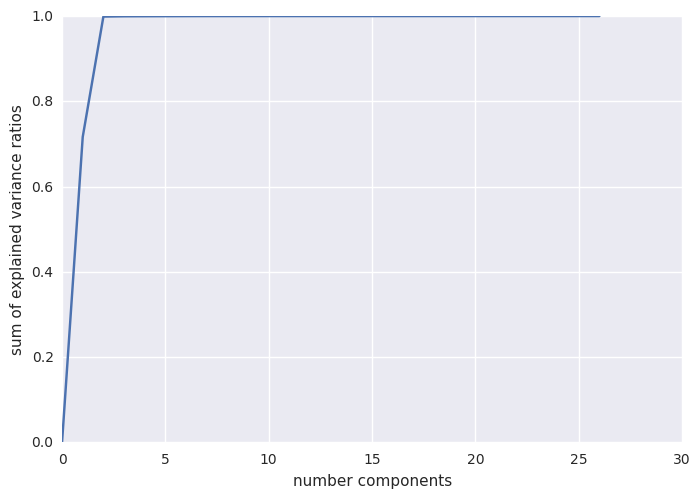

In [29]:
# perform PCA
pca_mod = PCA()
pca_mod.fit(train_data[all_features])

evr = pca_mod.explained_variance_ratio_
s_evr = np.cumsum(np.concatenate(([0], evr)))

print('Cumulative explained variance: \n', s_evr)

plt.plot(range(len(s_evr)),s_evr)
plt.xlabel('number components')
plt.ylabel('sum of explained variance ratios')
plt.ylim([0,1])
plt.show()

It turns out the applying PCA to our model will decrease the performance, probably because essential information is lost in the PCA process. Besides, we don't have millions of features which render the PCA process a must. So we will not apply PCA here.

In [49]:
def one_hot_encode(train_data):
    encoded_train_data = train_data

    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['PdDistrict_Num']), prefix='PdDistrict')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['DayOfWeek_Num']), prefix='DayOfWeek')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Street_Type']), prefix='Street_Type')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Season']), prefix='Season')], axis=1)
    encoded_train_data = pd.concat([encoded_train_data, 
                                    pd.get_dummies(pd.Series(encoded_train_data['Hour_Zone']), prefix='Hour_Zone')], axis=1)
    encoded_train_data = encoded_train_data.drop(['Street_Type', 'Season', 'Hour_Zone', 'DayOfWeek_Num', 'PdDistrict_Num', 
                                                  'Street1', 'Street2'], axis=1)

    return encoded_train_data

sample_number = 100000
mini_train_data, mini_dev_data, mini_train_labels, mini_dev_labels = train_test_split(train_data[:sample_number][all_features], 
                                                                                      train_data[:sample_number]['Category_Num'], 
                                                                                      test_size=0.5)

# K Neighbors
knn = KNeighborsClassifier()
knn.fit(mini_train_data, mini_train_labels)
pred_probs = knn.predict_proba(mini_dev_data)
knn_loss = log_loss(mini_dev_labels, pred_probs)

# Naive Bayes
gaussian = GaussianNB()
gaussian.fit(mini_train_data, mini_train_labels)
pred_probs = gaussian.predict_proba(mini_dev_data)
nb_loss = log_loss(mini_dev_labels, pred_probs)

# Logistic Regression
logreg = LogisticRegression(C=0.01, solver='newton-cg', tol=0.0001, multi_class='multinomial')
logreg.fit(one_hot_encode(mini_train_data), mini_train_labels)
pred_probs = logreg.predict_proba(one_hot_encode(mini_dev_data))
logreg_loss = log_loss(mini_dev_labels, pred_probs)

# Decision Tree
decision_tree = DecisionTreeClassifier(max_features='log2', max_depth=200, min_samples_split=50)
decision_tree.fit(mini_train_data, mini_train_labels)
pred_probs = decision_tree.predict_proba(mini_dev_data)
dt_loss = log_loss(mini_dev_labels, pred_probs)

# Random Forest
random_forest = RandomForestClassifier(max_features='log2', max_depth=200, n_estimators=128, min_samples_split=50, n_jobs=-1)
random_forest.fit(mini_train_data, mini_train_labels)
pred_labels = random_forest.predict(mini_dev_data)
pred_probs = random_forest.predict_proba(mini_dev_data)
rf_loss = log_loss(mini_dev_labels, pred_probs)

# Display the rank of the models
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'Decision Tree', 'K Neighbors'],
    'Log_Loss': [logreg_loss, rf_loss, nb_loss, dt_loss, knn_loss]})
print(models.sort_values(by='Log_Loss', ascending=True).reset_index(drop=True))

    Log_Loss                Model
0   2.290330        Random Forest
1   2.391730  Logistic Regression
2   5.338904          Naive Bayes
3   8.158537        Decision Tree
4  17.198601          K Neighbors


This cell may fail because the shape of the predicted probabilities matrix doesn't match the shape of the [n_samples * n_categories] matrix in the log_loss function. This is essentially a defect in the sklearn implementation of predict_proba function which is beyond our ability to fix. When the predict_proba function produces an all-zero column in the output matrix, it will omit it automatically. There is no way to prevent it from doing it, which results into the unmatched matrix shape. In case you encounter the failure. The only thing you can do is to run the cell again and hope that it passes.

The baseline model comparison shows that the Random Forest and Logistic Regression outperform other models greatly. Between these two models, we think Random Forest may be the better option theoretically and practically. Our data set contains a mix of continous numerica features and categorical features. The scope, mean, and variance of those feature variables are very different. The Random Forest model will split at the best point of a feature variable, so whether it is continuous or categorical doesn't matter that much for Random Forest. In contrast, the best practice for Logistic Regression is to one-hot encode all categorical features before training the model. Since we have a huge number of categorical features, one-hot encoding will increase the scale of our train data set to the next level and we will end up having a pretty sparse train data matrix. Even if we do that, its score in the baseline comparison is not as good as the Random Forest. We didn't include the score of SVM and Nerual Network here but we have done that sapareately. Training SVM and Neural Network with huge data set will consume incredibly amount of time and computer memory, i.e., up to 10 hours to train only 10w samples with a 8 GM memory computer. Besides, their performance are not as good as Random Forest either. SVM beats other models when the feaure number is greater than the sample number, while neural network is very sensitive to the tunning of hypeparameters. We believe that these two are not the best models for this project. From now on, we will stick to the Random Forest in the later sections.

In [50]:
# Divide data into train and dev data set and conduct cross-validation
# Use all samples here to get a comprehensive insight of its performance and use the result here for error analysis 
mini_train_data, mini_dev_data, mini_train_labels, mini_dev_labels = train_test_split(train_data[all_features], 
                                                                                      train_data['Category_Num'], 
                                                                                      test_size=0.5)

random_forest = RandomForestClassifier(max_features='log2', max_depth=150, n_estimators=160, min_samples_split=50, 
                                       n_jobs=-1)
random_forest.fit(mini_train_data, mini_train_labels)

pred_probs = random_forest.predict_proba(mini_dev_data)
pred_labels = random_forest.predict(mini_dev_data)

if mini_dev_labels.nunique() != pred_probs.shape[1]:
    print('Please run the cell again to get the multiclass loss.')
else:
    total_loss = log_loss(mini_dev_labels, pred_probs)
    print('The multiclass loss of Random Forest model is %.4f' % total_loss)
    
    rf_accuracy = np.mean(mini_dev_labels == pred_labels)
    print('The accuracy of Random Forest model is %.4f' % rf_accuracy)
    
    feature_weights = pd.DataFrame({'Feature': all_features, 'Weight': random_forest.feature_importances_})
    feature_weights = feature_weights.sort_values(by='Weight', ascending=False).reset_index(drop=True)
    print(feature_weights)

The multiclass loss of Random Forest model is 2.3050
The accuracy of Random Forest model is 0.3178
            Feature    Weight
0            Minute  0.099437
1           Rot30_Y  0.059223
2           Rot45_Y  0.055692
3                 Y  0.054881
4           Rot60_X  0.053431
5              Hour  0.052918
6           Rot60_Y  0.052878
7             Angle  0.051914
8           Rot45_X  0.050954
9           Rot30_X  0.050496
10             Year  0.050448
11                X  0.049984
12           Radius  0.049735
13              Day  0.037540
14          Street1  0.035805
15       WeekOfYear  0.032121
16        Hour_Zone  0.025476
17            Month  0.022721
18    DayOfWeek_Num  0.021150
19          Street2  0.018414
20  Is_Intersection  0.017630
21         Is_Block  0.015974
22   PdDistrict_Num  0.015441
23           Season  0.011396
24      Street_Type  0.007306
25       Is_Weekend  0.007034


It is very suprising that Minute is the most important feature, while the Month just doesn't matter for Random Forest. This tells us that never ignoring a feature or put extra weights on a feature based on intuition. Only data itself can judge whether a feature is important or not. However, it is also possible that the model gets confused here, and overfit for the noise in the Minute feature. If that is true, this model will do a poor job in prediction. Here we believe that these features are weighted correctly, because we have a large number of trees in the forest.

In [51]:
# Exclude unimportant features from the features set for the final model
weight_threshold = 0
data_features = feature_weights['Feature'][feature_weights['Weight'] > 0.02]
print('The select features are as following:')
print(data_features)

data_features = data_features.values
print('The count of selected features is %d' % len(data_features))

The select features are as following:
0            Minute
1           Rot30_Y
2           Rot45_Y
3                 Y
4           Rot60_X
5              Hour
6           Rot60_Y
7             Angle
8           Rot45_X
9           Rot30_X
10             Year
11                X
12           Radius
13              Day
14          Street1
15       WeekOfYear
16        Hour_Zone
17            Month
18    DayOfWeek_Num
Name: Feature, dtype: object
The count of selected features is 19


# ERROR ANALYSIS

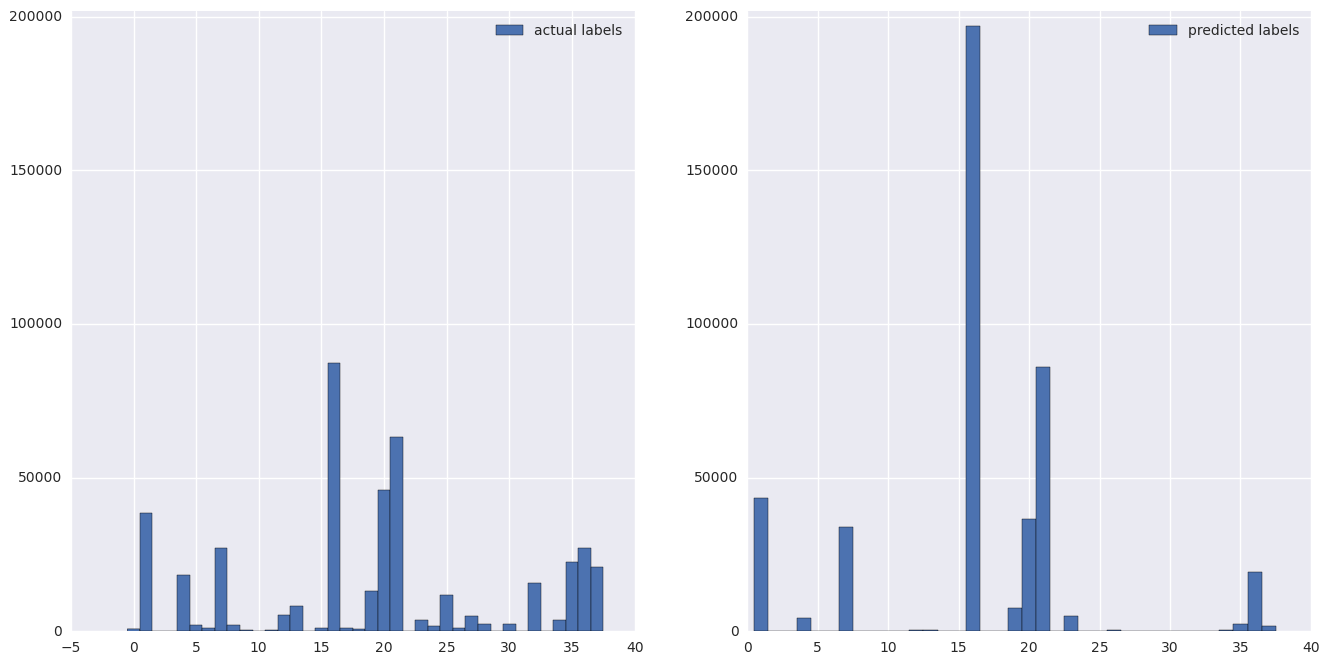

In [52]:
#Histogram of predictions

# Upper y-limit is the max of the two occurences + some fraction of the max
y_max = max(max(pd.Series(pred_labels).value_counts()), max(pd.Series(mini_dev_labels).value_counts()))
y_upper = y_max + 0.025 * y_max
# Originally: ax.set_ylim(0,170000)

fig = plt.figure(figsize = (16,8))

ax = fig.add_subplot(121)
ax.set_ylim(0, y_upper)
plt.hist(mini_dev_labels, bins=np.arange(39)-0.5, label='actual labels')
plt.legend(loc='upper right')

ax = fig.add_subplot(122)
ax.set_ylim(0, y_upper)
plt.hist(pred_labels, bins=np.arange(39)-0.5, label='predicted labels')
l = plt.legend(loc='upper right')

The analysis of the actual vs. predicted labels show that our model is overpredicting 5 labels and completely ignores many others. To remedy that, we are going to try to _"balance"_ the classifier weights based on the prior distribution

In [55]:
random_forest1 = RandomForestClassifier(max_features='log2', max_depth=150, n_estimators=160, min_samples_split=50,
                                        class_weight='balanced', n_jobs=-1)
random_forest1.fit(mini_train_data, mini_train_labels)
pred_probs1 = random_forest1.predict_proba(mini_dev_data)
pred_labels1 = random_forest1.predict(mini_dev_data)

rf_accuracy1 = np.mean(mini_dev_labels == pred_labels1)
print('The accuracy of Random Forest model is {0:4f}'.format(rf_accuracy1))

if mini_dev_labels.nunique() != pred_probs1.shape[1]:
    print('Please run the cell again to get the multiclass loss.')
else:
    total_loss1 = log_loss(mini_dev_labels, pred_probs1)
    print('The multiclass loss of Random Forest model is {0:4f}'.format(total_loss1))

The accuracy of Random Forest model is 0.188920
The multiclass loss of Random Forest model is 2.813872


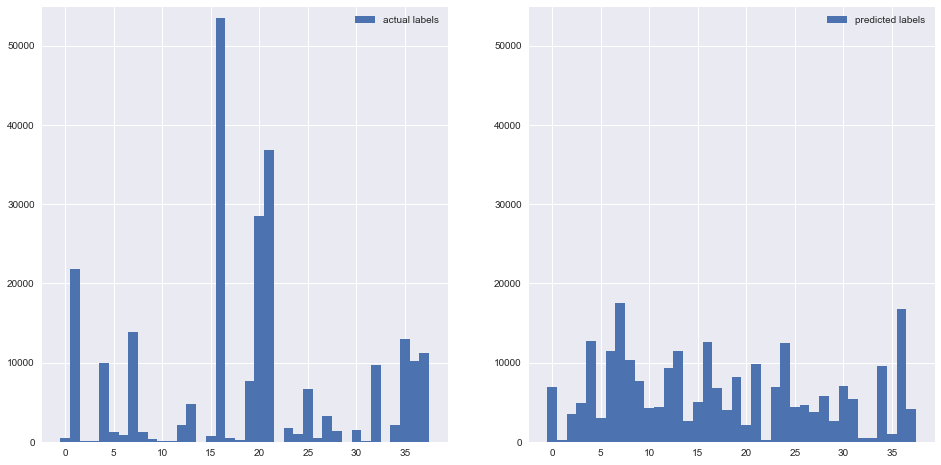

In [60]:
#Histogram of predictions

# Upper y-limit is the max of the two occurences + some fraction of the max
y_max = max(max(pd.Series(pred_labels1).value_counts()), max(pd.Series(mini_dev_labels).value_counts()))
y_upper = y_max + 0.025 * y_max

fig = plt.figure(figsize = (16,8))

ax = fig.add_subplot(121)
ax.set_ylim(0,y_upper)
plt.hist(mini_dev_labels, bins=np.arange(39)-0.5, label='actual labels')
plt.legend(loc='upper right')

ax = fig.add_subplot(122)
ax.set_ylim(0,y_upper)
plt.hist(pred_labels1, bins=np.arange(39)-0.5, label='predicted labels')
l = plt.legend(loc='upper right')

While this model reduces overprediction of few labels (and has more predicted labels), the overall log_loss accuracy is worse. So we are going to continue to use the default option for the class weigths

### Outliers

In [63]:
# let's create a vector of log_loss for each row
pred_probs1 = pred_probs.copy()
labels = [x for x in range(39)]
llv = np.zeros(pred_probs1.shape[0])

for row in range(pred_probs1.shape[0]):
    llv[row] = log_loss([mini_dev_labels.iloc[row]],pred_probs1[row, :].reshape(1,39), labels = labels)

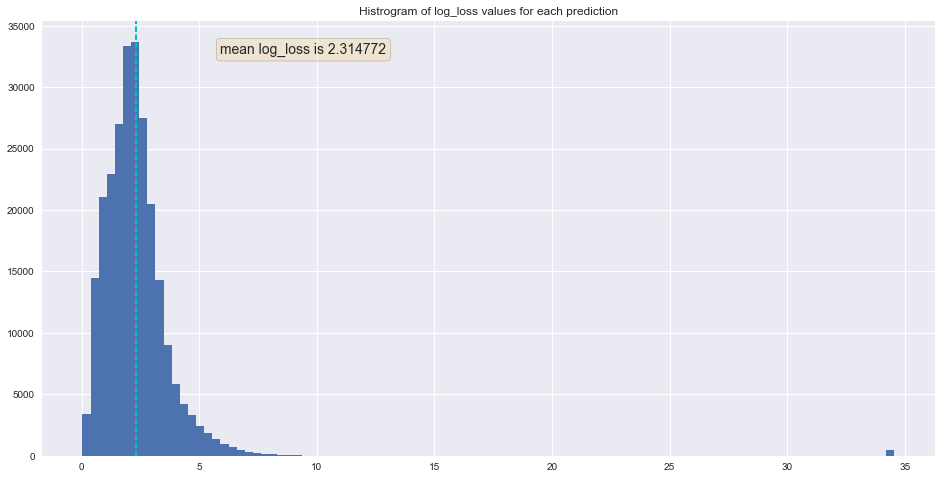

In [69]:
#print(np.mean(llv))
mean_loss = log_loss(mini_dev_labels, pred_probs)
fig = plt.figure(figsize = (16,8))
ax = fig.add_subplot(111)
result = plt.hist(llv, bins = 100)
plt.title('Histrogram of log_loss values for each prediction')
plt.axvline(mean_loss, color='c', linestyle='dashed', linewidth=2)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
title_string = "mean log_loss is {0:3f}".format(mean_loss)
txt = ax.text(0.0, 0.95, title_string, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

We see that there are a few outliers in the neighborhood of 35

### Baseline log_loss
For each row, a uniform probability prediction (no machine learning required), where each label has a 1/39 probability would give a log_loss score of:  
$$
\begin{aligned}
log\_loss &= -\log(\frac{1}{39})  \\
          &= 3.663562
\end{aligned}
$$


In [70]:
# baseline log_loss for uniform distribution (where all probas are 1)
print("The log_loss from uniform probability (i.e, no choice) is: {0:5f}".format(-math.log(1/39)))

The log_loss from uniform probability (i.e, no choice) is: 3.663562


One quick fix is to find all the labels whose mean log_loss score is above the baseline log_loss score and replace those labels with an "I don't know" probability where each label is equal probability of $\frac{1}{39}$

In [72]:
# for each category, recompute the log_loss score
sum_llv = 0
sum_size = 0
mean_llv_per_label = np.empty((39,))
for c in range(39):
    size = llv[pred_labels == c].shape[0]
    if size:
        mean_llv_per_label[c] = np.mean(llv[pred_labels == c])
        print("for label: {0:2d}, there are {1:3} predictions with the mean log_loss of: {2:5f}"
          .format(c,size,mean_llv_per_label[c]))
        sum_llv += mean_llv_per_label[c]*size
        sum_size += size
print(sum_llv/sum_size)



for label:  1, there are 22835 predictions with the mean log_loss of: 2.710555
for label:  4, there are 1477 predictions with the mean log_loss of: 2.539563
for label:  5, there are 285 predictions with the mean log_loss of: 1.960066
for label:  7, there are 16167 predictions with the mean log_loss of: 2.112547
for label: 12, there are  74 predictions with the mean log_loss of: 3.116887
for label: 13, there are 211 predictions with the mean log_loss of: 2.197846
for label: 16, there are 121975 predictions with the mean log_loss of: 2.245355
for label: 17, there are  18 predictions with the mean log_loss of: 1.751377
for label: 19, there are 4974 predictions with the mean log_loss of: 1.752043
for label: 20, there are 24762 predictions with the mean log_loss of: 2.489941
for label: 21, there are 49518 predictions with the mean log_loss of: 2.348669
for label: 23, there are 2182 predictions with the mean log_loss of: 1.746871
for label: 25, there are   6 predictions with the mean log_los

Unfortunately, none of the labels have a mean log_loss score higher than 3.6, so this fix is not helpful.

### What are the worse performing predictions?

In [89]:
# the top 10 worse performing partitions are
ind = np.argpartition(llv, -10)[-10:]
print("Worst predictions are:")
print(llv[ind])

print("for these indexes")
print(ind)


#print(pred_labels[ind])
#pred_probs[ind]

print("these are the predicted labels")
print(pred_labels[ind])

print("these are the actual labels")
print(mini_dev_labels.iloc[ind])

tmp = mini_dev_data.copy().iloc[500000:]
print("there are the inccorect dev points")
for i in ind:
    print(mini_dev_data.iloc[i])




Worst predictions are:
[ 34.53877639  34.53877639  34.53877639  34.53877639  34.53877639
  34.53877639  34.53877639  34.53877639  34.53877639  34.53877639]
for these indexes
[ 68504  24395   7257 213286 168230 230328 223373  76619 200522  68419]
these are the predicted labels
[ 7 16 20 20 19 16 16 16 16 16]
these are the actual labels
484715     0
452675    17
59376     15
403503    24
82045     27
419937     8
349045    18
167175     0
389182    23
396994    10
Name: Category_Num, dtype: int64
there are the inccorect dev points
Minute               26.000000
Hour                 11.000000
Day                  13.000000
Month                 7.000000
Year                  5.000000
Hour_Zone             1.000000
Season                1.000000
WeekOfYear           13.000000
DayOfWeek_Num         3.000000
Is_Weekend            1.000000
Street1             651.000000
Street2            1379.000000
Street_Type          19.000000
PdDistrict_Num        9.000000
Is_Intersection       1.000000


Unfortunately, there doesn't seem to be an obvious issue with these samples.

### Smoothing the predictions 
We are going to add a small value to all the predictions so that we don't have any 0 value probability.   
Note that while the $\sum{row_{predictions}} > {1}$ for each row of the prediction matrix, this is not an issue. Log_loss function used by Python and Kaggle rescales the matrix back to $\sum{row_{predictions}} = 1$.

In [90]:
# Smoothing the predictions - We are going to add a small value to each probability and compute the log_loss score
pred_probs2 = pred_probs.copy()
x = []
y = []
for s in range(1, 100):
    smoothing = s*(10**-5) 
    x.append(smoothing)
    #print(smoothing)
    t3 = np.add(pred_probs2 , (np.ones(pred_probs2.shape)*smoothing))
    ll = log_loss(mini_dev_labels, t3)
    y.append(ll)
    #print(smoothing,ll)

We get the lowest log_loss score of: 2.269870, with smooting parameter: 0.000200
The improvement is 0.033872%


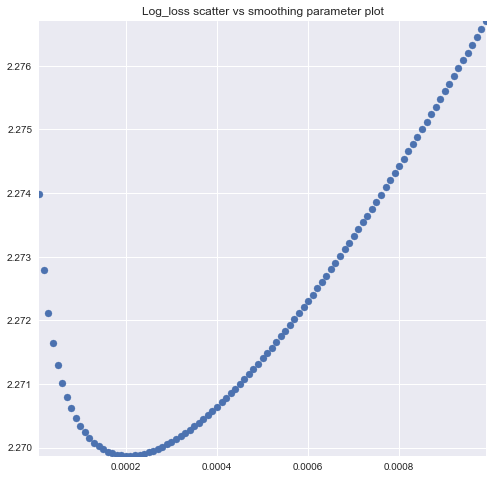

In [91]:
# Plotting the log_loss scores to find out the min value
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)
ax.set_xlim(min(x),max(x))
ax.set_ylim(min(y),max(y))
plt.scatter(x,y)
plt.title('Log_loss scatter vs smoothing parameter plot')
min_value = np.argmin(y)

print("We get the lowest log_loss score of: {0:f}, with smooting parameter: {1:f}".
      format(y[min_value],x[min_value]))
print("The improvement is {0:3f}%".format(1-(y[min_value]/2.34945027229)))

NOTE: End of Testing for Jerry3 section

We noticed that excluding unimportant parameters can improve the accuracy slightly. This is probably because the model is prone to noise and the predicted results have greater variance when unimportant features are there.

# MODEL PARAMETER TUNING

In [47]:
# Warning: doing cross validation on large data set will be extremly time and memory consuming. It takes a computer
# with 16GB memory about 45-60 mins to run the cross validation model below. Carefully select the tunning parameters
# set before running.

n_estimators = [32, 64, 128, 160]
max_features = ['sqrt', 'log2', None]
max_depth = [10, 50, 100, 125, 150, None]
min_samples_split = [10, 50, 100, 200, 500]
# Note: Daghan is testing with class_weight as well

cv_clf = GridSearchCV(RandomForestClassifier(n_jobs=2), {'n_estimators': n_estimators, 
                                                 'max_features': max_features,
                                                 'max_depth': max_depth,
                                                 'min_samples_split': min_samples_split})

# The "optimal" parameters computed here may actually increase the submission score sometime, 
# probably due to overfitting.
cv_clf.fit(train_data[:50000][data_features], train_data[:50000]['Category_Num'])
print(cv_clf.best_params_)

{'min_samples_split': 50, 'n_estimators': 160, 'max_depth': 150, 'max_features': 'log2'}


/Users/PJ/anaconda/envs/python3/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


We understand that the GridSeachCV use 'label prediction accuracy score' as the metric by default, which is not necessarily consistent with the log-loss. However, we cannot use log-loss in it, though it accepts us to pass a score metric parameter. If we use log-loss in GridSeachCV, we will encounter exactly the same failure as dicussed in the Model Comparison section, the matrix shape unmatch. Since this is a defect in sklearn library which we cannot fix, we will use the default scroe metric here.

# SUBMISSION RESULTS GENERATION

In [97]:
# We will use the Random Forest to establish the baseline.
# Retrain the Random Forest model with full train data
random_forest = RandomForestClassifier(max_features='log2', max_depth=150, n_estimators=160, min_samples_split=50)
random_forest.fit(train_data[data_features], train_data['Category_Num'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=150, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=50, min_weight_fraction_leaf=0.0,
            n_estimators=160, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [102]:
transformed_test_data = test_data[data_features]
transformed_test_data.info()

# Print which feature column contains NA value
print(transformed_test_data.isnull().any())

# Fill the NA feature fields in the test data with the mean of that feature
transformed_test_data = transformed_test_data.fillna(transformed_test_data.mean())

predictions = random_forest.predict_proba(transformed_test_data)
print(predictions.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884262 entries, 0 to 884261
Data columns (total 16 columns):
Minute             884262 non-null int64
Rot60_X            877982 non-null float64
Hour               884262 non-null int64
Is_Intersection    884262 non-null int64
Rot30_Y            877982 non-null float64
Rot45_Y            877982 non-null float64
Y                  884262 non-null float64
Year               884262 non-null int64
X                  884262 non-null float64
Radius             884262 non-null float64
Angle              884262 non-null float64
PdDistrict_Num     884262 non-null int64
Rot60_Y            877982 non-null float64
Rot45_X            877982 non-null float64
Street1            884262 non-null int64
Rot30_X            877982 non-null float64
dtypes: float64(10), int64(6)
memory usage: 107.9 MB
Minute             False
Rot60_X             True
Hour               False
Is_Intersection    False
Rot30_Y             True
Rot45_Y             True
Y         

In [103]:
# Smooth the predictions
predictions = np.add(predictions , (np.ones(predictions.shape) * smoothing_parameter))

In [104]:
# Generate the submission dataframe
submission = np.column_stack((range(predictions.shape[0]), predictions))
submission = pd.DataFrame(data=submission, columns=['Id'] + criminal_labels)
submission['Id'] = submission['Id'].astype(int)
submission.head()

Id     ARSON   ASSAULT  BAD CHECKS  BRIBERY  BURGLARY  DISORDERLY CONDUCT  \
0   0  0.004187  0.096505    0.000591  0.00088  0.037846            0.007040   
1   1  0.000963  0.078045    0.000200  0.00020  0.004475            0.008888   
2   2  0.006072  0.080931    0.000200  0.00020  0.081961            0.001851   
3   3  0.002296  0.086461    0.000681  0.00020  0.080691            0.002364   
4   4  0.001828  0.095472    0.000766  0.00020  0.060177            0.003696   

   DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  DRUNKENNESS     ...       \
0                     0.003104       0.088352     0.005010     ...        
1                     0.004305       0.078487     0.012626     ...        
2                     0.007001       0.025764     0.006707     ...        
3                     0.001309       0.030159     0.004571     ...        
4                     0.004168       0.029449     0.008300     ...        

   SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY   SUICIDE  SUSPICIOUS OCC  \
0                     0.0002         0.010938  0.000345        0.038377   
1                     0.0002         0.004902  0.000200        0.033642   
2                     0.0002         0.009797  0.005591        0.045300   
3                     0.0002         0.010580  0.001392        0.043591   
4                     0.0002         0.009898  0.001189        0.038024   

     TREA  TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0  0.0002  0.012557   0.050464       0.041027  0.086019     0.016124  
1  0.0002  0.003309   0.032091       0.045251  0.096927     0.026322  
2  0.0002  0.007184   0.049624       0.050716  0.022016     0.011259  
3  0.0002  0.005810   0.055528       0.056426  0.025032     0.006899  
4  0.0002  0.008818   0.061446       0.064998  0.046292     0.015552  

[5 rows x 40 columns]

In [ ]:
# Save the submission csv file
submission.to_csv('submission.csv.gz', index=False, compression='gzip')

# APPENDIX

What do we want to put here?